# Librerias


In [2]:
import datetime
import os
import pickle
import sys
import time as tm
from copy import deepcopy

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cftime
import matplotlib.dates
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import netCDF4 as nc
import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as pyo
from scipy.interpolate import griddata
from tqdm.notebook import tqdm

import research_helpers as rh


# Análisis: Variable "huss" (Near surface specific humidity) de manera independiente


## Carga de Datos


In [3]:
root_folder = 'cordex_models'
experiments = ['historical', 'rcp85']
primary_variable = 'huss'
complementary_variables = ['uas', 'vas', 'tas']

# Obtenemos las carpetas de los modelos
huss_historical_folders = [f for f in os.listdir(os.path.join(
    root_folder, 'historical', primary_variable)) if os.path.isdir(os.path.join(root_folder, 'historical', primary_variable, f))]
huss_rcp85_folders = [f for f in os.listdir(os.path.join(
    root_folder, 'rcp85', primary_variable)) if os.path.isdir(os.path.join(root_folder, 'rcp85', primary_variable, f))]

# Cargamos los datasets de cada modelo
huss_historical_datasets = [nc.MFDataset(os.path.join(
    root_folder, 'historical', primary_variable, f, '*.nc')) for f in huss_historical_folders]
huss_rcp85_datasets = [nc.MFDataset(os.path.join(
    root_folder, 'rcp85', primary_variable, f, '*.nc')) for f in huss_rcp85_folders]

# Reportamos
print(f'Cantidad de modelos históricos: {len(huss_historical_datasets)}')
print(f'Cantidad de modelos RCP85: {len(huss_rcp85_datasets)}')


Cantidad de modelos históricos: 24
Cantidad de modelos RCP85: 24


In [4]:
# Comprobamos que los modelos históricos y RCP85 coincidan
huss_historical_models_info = ['_'.join(
    f.split('_')[1:3] + f.split('_')[5:-1]) for f in huss_historical_folders]
huss_rcp85_models_info = [
    '_'.join(f.split('_')[1:3] + f.split('_')[5:-1]) for f in huss_rcp85_folders]
# Modelos coincidentes
joined_models = list(set(huss_historical_models_info).intersection(
    set(huss_rcp85_models_info)))
# Modelos no coincidentes
not_joined_models = list(set(huss_historical_models_info).symmetric_difference(
    set(huss_rcp85_models_info)))
print(f'Cantidad de modelos coincidentes: {len(joined_models)}')
print(f'Modelos no coincidentes: {not_joined_models}' if len(
    not_joined_models) > 0 else 'No hay modelos no coincidentes')


Cantidad de modelos coincidentes: 24
No hay modelos no coincidentes


In [5]:
# Filtramos los modelos que poseen las variables de lat y lon con una única dimensión
huss_historical_datasets = [f for f in huss_historical_datasets if len(
    f.variables['lat'].shape) == 1 and len(f.variables['lon'].shape) == 1]
huss_rcp85_datasets = [f for f in huss_rcp85_datasets if len(
    f.variables['lat'].shape) == 1 and len(f.variables['lon'].shape) == 1]
# Reportamos
print(
    f'Cantidad de modelos históricos con lat y lon de una dimensión: {len(huss_historical_datasets)}')
print(
    f'Cantidad de modelos RCP85 con lat y lon de una dimensión: {len(huss_rcp85_datasets)}')


Cantidad de modelos históricos con lat y lon de una dimensión: 8
Cantidad de modelos RCP85 con lat y lon de una dimensión: 8


Trabajaremos con los 8 modelos que poseen las dimensiones de latitud y longitud en 1 dimensión. Estos poseen experimentos de tipo historical y rcp85.


# Anomalías


In [6]:
# Inicializamos el diccionario de modelos
huss_historical_data = rh.init_models_dict(huss_historical_datasets)
huss_rcp85_data = rh.init_models_dict(huss_rcp85_datasets)


In [7]:
# Calculamos los ciclos estacionales, ciclos estacionales ajustados y anomalías de los modelos históricos
# Tambien extraemos las variables temporales, espaciales y de identificación de cada modelo

for model in tqdm(huss_historical_datasets):
    # Obtenemos el nombre del modelo
    model_name = model.model_id + '_' + \
        model.driving_model_id + '_' + model.CORDEX_domain
    # Obtenemos la serie de tiempo de la variable huss
    time_series_data = model['huss'][:]
    # Obtenemos las latitudes y longitudes
    lat_data = model['lat'][:]
    lon_data = model['lon'][:]
    # Calculamos la serie de anomalías
    anomaly_series_iter, monthly_mean_fit_iter, monthly_mean_iter = rh.monthly_anomaly_series(
        time_series_data, lat_data, lon_data)

    # Guardamos los datos en el diccionario
    huss_historical_data[model_name]['anomaly_series'] = anomaly_series_iter
    huss_historical_data[model_name]['monthly_mean_fit'] = monthly_mean_fit_iter
    huss_historical_data[model_name]['monthly_mean'] = monthly_mean_iter
    huss_historical_data[model_name]['lat'] = lat_data
    huss_historical_data[model_name]['lon'] = lon_data
    huss_historical_data[model_name]['time'] = cftime.num2date(
        model['time'][:], model['time'].units, calendar=model['time'].calendar)
    huss_historical_data[model_name]['huss'] = model['huss'][:]
    huss_historical_data[model_name]['model_id'] = model.model_id
    huss_historical_data[model_name]['driving_model_id'] = model.driving_model_id
    huss_historical_data[model_name]['cordex_domain'] = model.CORDEX_domain
    print(f'Anomalías calculadas para {model_name}.')


  0%|          | 0/8 [00:00<?, ?it/s]

Anomalías calculadas para SMHI-RCA4_CCCma-CanESM2_SAM-44i.
Anomalías calculadas para SMHI-RCA4_CSIRO-QCCCE-CSIRO-Mk3-6-0_SAM-44i.
Anomalías calculadas para SMHI-RCA4_IPSL-IPSL-CM5A-MR_SAM-44i.
Anomalías calculadas para SMHI-RCA4_MIROC-MIROC5_SAM-44i.
Anomalías calculadas para SMHI-RCA4_MOHC-HadGEM2-ES_SAM-44i.
Anomalías calculadas para SMHI-RCA4_MPI-M-MPI-ESM-LR_SAM-44i.
Anomalías calculadas para SMHI-RCA4_NCC-NorESM1-M_SAM-44i.
Anomalías calculadas para SMHI-RCA4_NOAA-GFDL-GFDL-ESM2M_SAM-44i.


In [8]:
# Calculamos los ciclos estacionales, ciclos estacionales ajustados y anomalías de los modelos RCP85
# Tambien extraemos las variables temporales, espaciales y de identificación de cada modelo

for model in tqdm(huss_rcp85_datasets):
    # Obtenemos el nombre del modelo
    model_name = model.model_id + '_' + \
        model.driving_model_id + '_' + model.CORDEX_domain
    # Obtenemos las latitudes y longitudes
    lat_data = model['lat'][:]
    lon_data = model['lon'][:]

    # Guardamos los datos en el diccionario
    huss_rcp85_data[model_name]['lat'] = lat_data
    huss_rcp85_data[model_name]['lon'] = lon_data
    huss_rcp85_data[model_name]['time'] = cftime.num2date(
        model['time'][:], model['time'].units, calendar=model['time'].calendar)

    # Filtramos los datos RCP85 temporalmente para que partan en una misma fecha
    start_date_rcp85 = cftime.datetime(
        2006, 1, 1, calendar=model['time'].calendar)
    end_date_rcp85 = cftime.datetime(
        2100, 1, 1, calendar=model['time'].calendar)
    time_index = np.where((huss_rcp85_data[model_name]['time'] >= start_date_rcp85) & (
        huss_rcp85_data[model_name]['time'] < end_date_rcp85))[0]
    huss_rcp85_data[model_name]['time'] = huss_rcp85_data[model_name]['time'][time_index]

    # Obtenemos la serie de tiempo de la variable huss
    time_series_data = model['huss'][time_index, :, :]

    # Calculamos la serie de anomalías
    anomaly_series_iter, monthly_mean_fit_iter, monthly_mean_iter = rh.monthly_anomaly_series(
        time_series_data, lat_data, lon_data)
    huss_rcp85_data[model_name]['anomaly_series'] = anomaly_series_iter
    huss_rcp85_data[model_name]['monthly_mean_fit'] = monthly_mean_fit_iter
    huss_rcp85_data[model_name]['monthly_mean'] = monthly_mean_iter

    huss_rcp85_data[model_name]['huss'] = model['huss'][time_index, :, :]
    huss_rcp85_data[model_name]['model_id'] = model.model_id
    huss_rcp85_data[model_name]['driving_model_id'] = model.driving_model_id
    huss_rcp85_data[model_name]['cordex_domain'] = model.CORDEX_domain
    print(f'Anomalías calculadas para {model_name}.')


  0%|          | 0/8 [00:00<?, ?it/s]

Anomalías calculadas para SMHI-RCA4_CCCma-CanESM2_SAM-44i.
Anomalías calculadas para SMHI-RCA4_CSIRO-QCCCE-CSIRO-Mk3-6-0_SAM-44i.
Anomalías calculadas para SMHI-RCA4_IPSL-IPSL-CM5A-MR_SAM-44i.
Anomalías calculadas para SMHI-RCA4_MIROC-MIROC5_SAM-44i.
Anomalías calculadas para SMHI-RCA4_MOHC-HadGEM2-ES_SAM-44i.
Anomalías calculadas para SMHI-RCA4_MPI-M-MPI-ESM-LR_SAM-44i.
Anomalías calculadas para SMHI-RCA4_NCC-NorESM1-M_SAM-44i.
Anomalías calculadas para SMHI-RCA4_NOAA-GFDL-GFDL-ESM2M_SAM-44i.


## Filtro Geográfico

A continuación, filtramos los datos que tenemos para que solo queden los que se encuentren en el territorio de la zona central de Chile.  
La zona central de Chile no tiene límites geográficos precisos definidos por coordenadas específicas, ya que es una delimitación más bien subjetiva y puede variar según diferentes interpretaciones. Sin embargo, generalmente se considera que la zona central abarca desde aproximadamente el río Aconcagua, al norte, hasta el río Biobío, al sur.

A modo de referencia, a continuación se mencionan algunas coordenadas aproximadas que podrían considerarse como límites de la zona central de Chile:

    Latitud máxima: Alrededor de 33° Sur (cerca de la ciudad de La Serena).
    Latitud mínima: Alrededor de 36° Sur (cerca de la ciudad de Concepción).
    Longitud máxima: Alrededor de 71° Oeste (punta oeste de la Región de Valparaíso).
    Longitud mínima: Alrededor de 73° Oeste (punto en la Región del Maule, cerca de Constitución).

Estas coordenadas son solo una referencia aproximada y pueden variar dependiendo de la definición específica que se utilice para delimitar la zona central de Chile.


In [9]:
cities = {
    'valparaiso': (-33.047238, -71.612688),
    'santiago': (-33.448890, -70.669265),
    'rancagua': (-34.170132, -70.740839),
    'concepcion': (-36.826141, -73.049819),
    'talca': (-35.426399, -71.655437),
    'chillan': (-36.606722, -72.103243),
    'curico': (-34.983333, -71.233333)
}


c:\Anaconda\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_coastline.zip

c:\Anaconda\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_0_boundary_lines_land.zip

c:\Anaconda\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_lakes.zip

c:\Anaconda\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/10m_physical/ne_10m_rivers_lake_centerlines.zip

c:\Anaconda\lib\site-packages\cartopy\mpl\style.py:76: UserWarning:

facecolor will have no effect as it has been defined as "never".

c:\Anaconda\lib\site-packages\cartopy\io\__init__.py:241: DownloadWarning:

Downloading: https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces_lines.zip



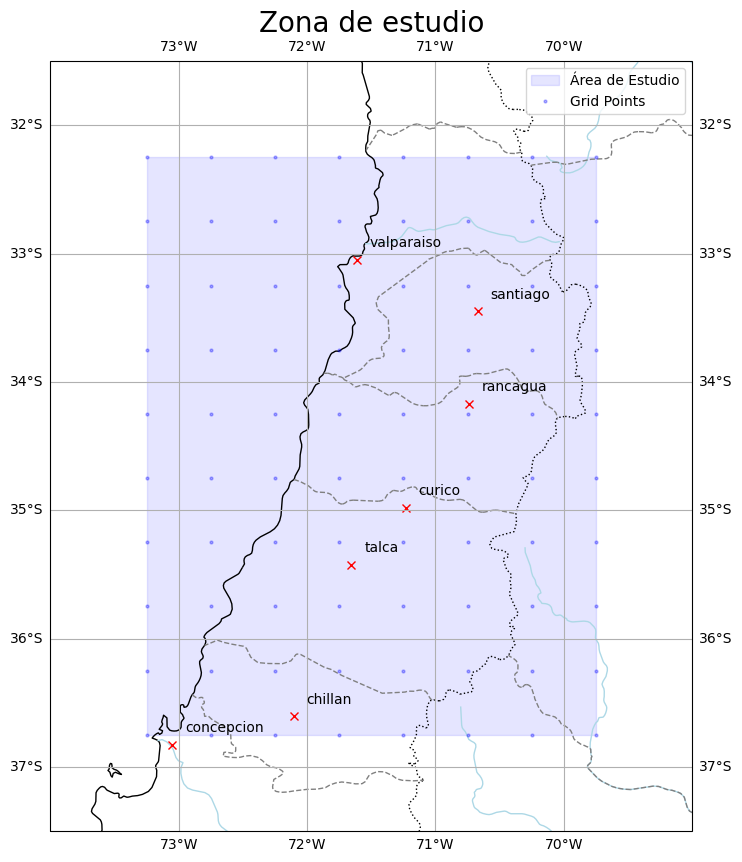

In [10]:
# Definimos los límites de Chile central
chile_central_lat = (-37, -32)
# chile_central_lon = (360 - 73, 360 - 71)
chile_central_lon = (-73.5, -69.5)
model = huss_historical_data['SMHI-RCA4_MIROC-MIROC5_SAM-44i']

lat_idx = np.where((model['lat'] >= chile_central_lat[0]) & (
    model['lat'] <= chile_central_lat[1]))[0]
lon_idx = np.where((model['lon'] >= chile_central_lon[0]) & (
    model['lon'] <= chile_central_lon[1]))[0]

lat_map = model['lat'][lat_idx]
lon_map = model['lon'][lon_idx]
points_map = np.array([(lat, lon) for lat in lat_map for lon in lon_map])

# Mostramos la zona de estudio de un modelo cualquiera
model = 'SMHI-RCA4_MIROC-MIROC5_SAM-44i'
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(
    projection=ccrs.PlateCarree()))
ax.set_extent([chile_central_lon[0]-0.5, chile_central_lon[1]+0.5,
              chile_central_lat[0]-0.5, chile_central_lat[1]+0.5], crs=ccrs.PlateCarree())
ax.coastlines(resolution='10m')
ax.add_feature(ccrs.cartopy.feature.BORDERS, linestyle=':')
ax.add_feature(ccrs.cartopy.feature.LAKES, color='lightblue')
ax.add_feature(ccrs.cartopy.feature.RIVERS, color='lightblue')
ax.gridlines(draw_labels=True, dms=True, x_inline=False,
             y_inline=False, crs=ccrs.PlateCarree())
for city in cities.keys():
    ax.plot(cities[city][1], cities[city][0],
            transform=ccrs.PlateCarree(), marker='x', color='red')
    # text
    ax.text(cities[city][1] + 0.1, cities[city][0] +
            0.1, city, transform=ccrs.PlateCarree())

# Graficar el área de los puntos
x = points_map[:, 1]
y = points_map[:, 0]
x_min = min(x)
x_max = max(x)
y_min = min(y)
y_max = max(y)
width = x_max - x_min
height = y_max - y_min
rect = plt.Rectangle((x_min, y_min), width, height,
                     alpha=0.1, color='blue', label='Área de Estudio')
ax.add_patch(rect)

# graficamos points_map como un area
ax.plot(points_map[:, 1], points_map[:, 0], 'bo', transform=ccrs.PlateCarree(
), label='Grid Points', alpha=0.3, markersize=2)

# Añadimos las regiones, dashed
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='10m',
    facecolor='none',
    edgecolor='gray',
    linestyle='--')
ax.add_feature(states_provinces, edgecolor='gray')
ax.set_title('Zona de estudio', fontsize=20)

ax.legend()
plt.show()


In [11]:
# Copiamos los datos de los modelos
huss_historical_data_chile_central = deepcopy(huss_historical_data)
huss_rcp85_data_chile_central = deepcopy(huss_rcp85_data)

# Filtramos los datos históricos segun los límites de Chile central
print('Filtrando datos históricos...')
for model in huss_historical_data_chile_central.keys():
    # Obtenemos los índices de las latitudes y longitudes de Chile central
    lat_index = np.where((huss_historical_data_chile_central[model]['lat'] >= chile_central_lat[0]) & (
        huss_historical_data_chile_central[model]['lat'] <= chile_central_lat[1]))[0]
    lon_index = np.where((huss_historical_data_chile_central[model]['lon'] >= chile_central_lon[0]) & (
        huss_historical_data_chile_central[model]['lon'] <= chile_central_lon[1]))[0]
    # Filtramos las latitudes y longitudes de Chile central
    huss_historical_data_chile_central[model]['lat'] = huss_historical_data_chile_central[model]['lat'][lat_index]
    huss_historical_data_chile_central[model]['lon'] = huss_historical_data_chile_central[model]['lon'][lon_index]
    # Filtramos las anomalías de Chile central
    huss_historical_data_chile_central[model]['anomaly_series'] = huss_historical_data_chile_central[
        model]['anomaly_series'][:, lat_index, :][:, :, lon_index]
    huss_historical_data_chile_central[model]['monthly_mean_fit'] = huss_historical_data_chile_central[
        model]['monthly_mean_fit'][:, lat_index, :][:, :, lon_index]
    huss_historical_data_chile_central[model]['monthly_mean'] = huss_historical_data_chile_central[
        model]['monthly_mean'][:, lat_index, :][:, :, lon_index]
    huss_historical_data_chile_central[model]['huss'] = huss_historical_data_chile_central[model]['huss'][:,
                                                                                                          lat_index, :][:, :, lon_index]
    print(f'Filtro geográfico aplicado para {model}.')
print()

# Filtramos los datos RCP85 segun los límites de Chile central
print('Filtrando datos RCP85...')
for model in huss_rcp85_data_chile_central.keys():
    # Obtenemos los índices de las latitudes y longitudes de Chile central
    lat_index = np.where((huss_rcp85_data_chile_central[model]['lat'] >= chile_central_lat[0]) & (
        huss_rcp85_data_chile_central[model]['lat'] <= chile_central_lat[1]))[0]
    lon_index = np.where((huss_rcp85_data_chile_central[model]['lon'] >= chile_central_lon[0]) & (
        huss_rcp85_data_chile_central[model]['lon'] <= chile_central_lon[1]))[0]
    # Filtramos las latitudes y longitudes de Chile central
    huss_rcp85_data_chile_central[model]['lat'] = huss_rcp85_data_chile_central[model]['lat'][lat_index]
    huss_rcp85_data_chile_central[model]['lon'] = huss_rcp85_data_chile_central[model]['lon'][lon_index]
    # Filtramos las anomalías de Chile central
    huss_rcp85_data_chile_central[model]['anomaly_series'] = huss_rcp85_data_chile_central[
        model]['anomaly_series'][:, lat_index, :][:, :, lon_index]
    huss_rcp85_data_chile_central[model]['monthly_mean_fit'] = huss_rcp85_data_chile_central[
        model]['monthly_mean_fit'][:, lat_index, :][:, :, lon_index]
    huss_rcp85_data_chile_central[model]['monthly_mean'] = huss_rcp85_data_chile_central[
        model]['monthly_mean'][:, lat_index, :][:, :, lon_index]
    huss_rcp85_data_chile_central[model]['huss'] = huss_rcp85_data_chile_central[model]['huss'][:,
                                                                                                lat_index, :][:, :, lon_index]
    print(f'Filtro geográfico aplicado para {model}.')


Filtrando datos históricos...
Filtro geográfico aplicado para SMHI-RCA4_CCCma-CanESM2_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_CSIRO-QCCCE-CSIRO-Mk3-6-0_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_IPSL-IPSL-CM5A-MR_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_MIROC-MIROC5_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_MOHC-HadGEM2-ES_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_MPI-M-MPI-ESM-LR_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_NCC-NorESM1-M_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_NOAA-GFDL-GFDL-ESM2M_SAM-44i.

Filtrando datos RCP85...
Filtro geográfico aplicado para SMHI-RCA4_CCCma-CanESM2_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_CSIRO-QCCCE-CSIRO-Mk3-6-0_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_IPSL-IPSL-CM5A-MR_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_MIROC-MIROC5_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_MOHC-HadGEM2-ES_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_MPI-M-MPI-ESM

## Promedio Espacial por Modelo


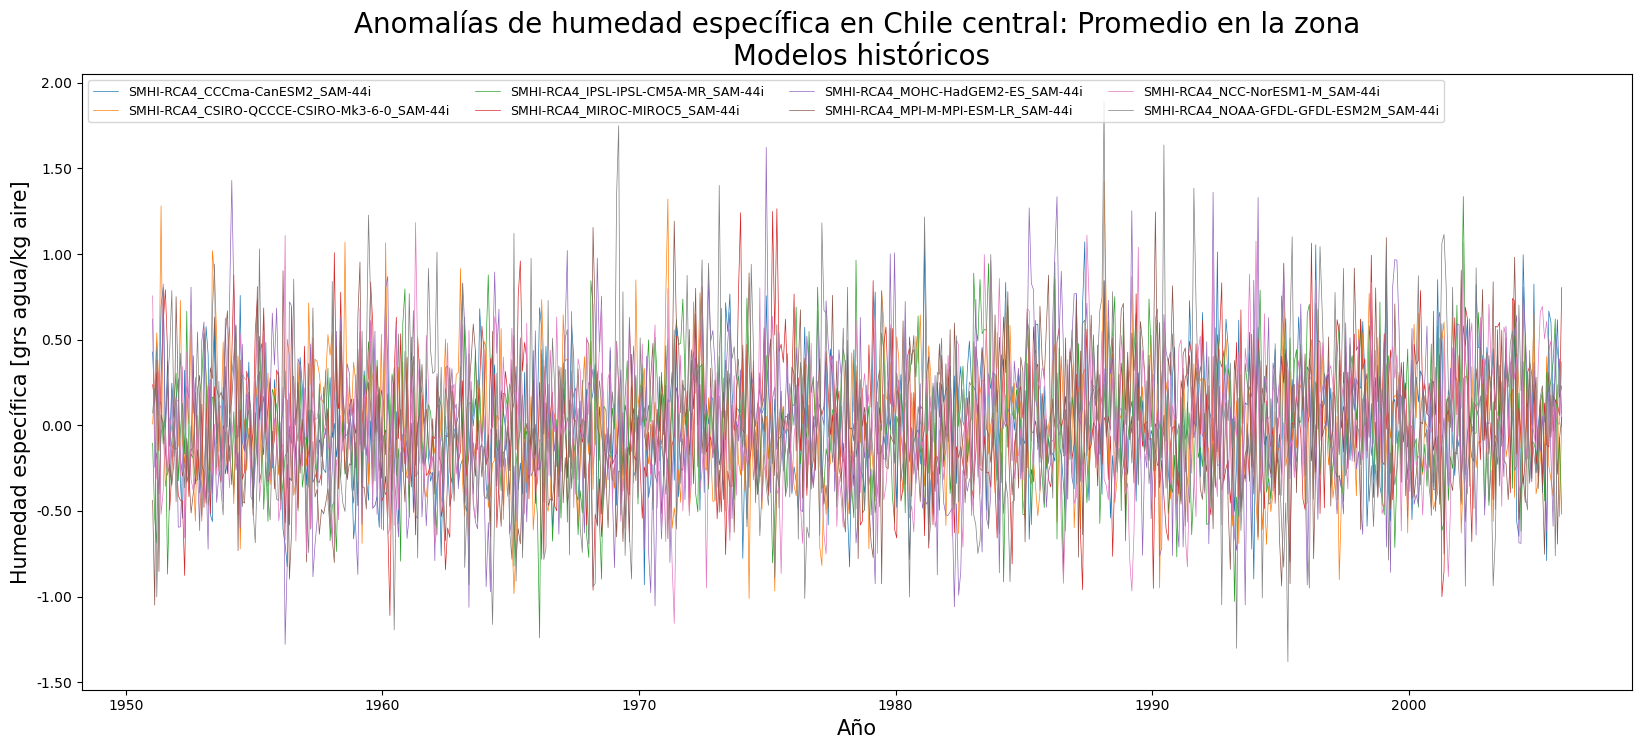

In [12]:
def kg2grams_formatter(x, pos):
    """
    Formatea un número en gramos.
    """
    return '{:.2f}'.format(x*1000)


# Graficamos las series de tiempo de las anomalías de los modelos históricos
fig, ax = plt.subplots(figsize=(20, 8))
for model in huss_historical_data_chile_central.keys():
    ax.plot(rh.cfdate2datetime(huss_historical_data_chile_central[model]['time']), huss_historical_data_chile_central[model]['anomaly_series'].mean(
        axis=(1, 2)), label=model, lw=0.5)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(kg2grams_formatter))
ax.set_title(
    'Anomalías de humedad específica en Chile central: Promedio en la zona\n Modelos históricos', fontsize=20)
ax.set_xlabel('Año', fontsize=15)
ax.set_ylabel('Humedad específica [grs agua/kg aire]', fontsize=15)
ax.legend(ncol=4, fontsize=9, loc='upper left')
plt.show()


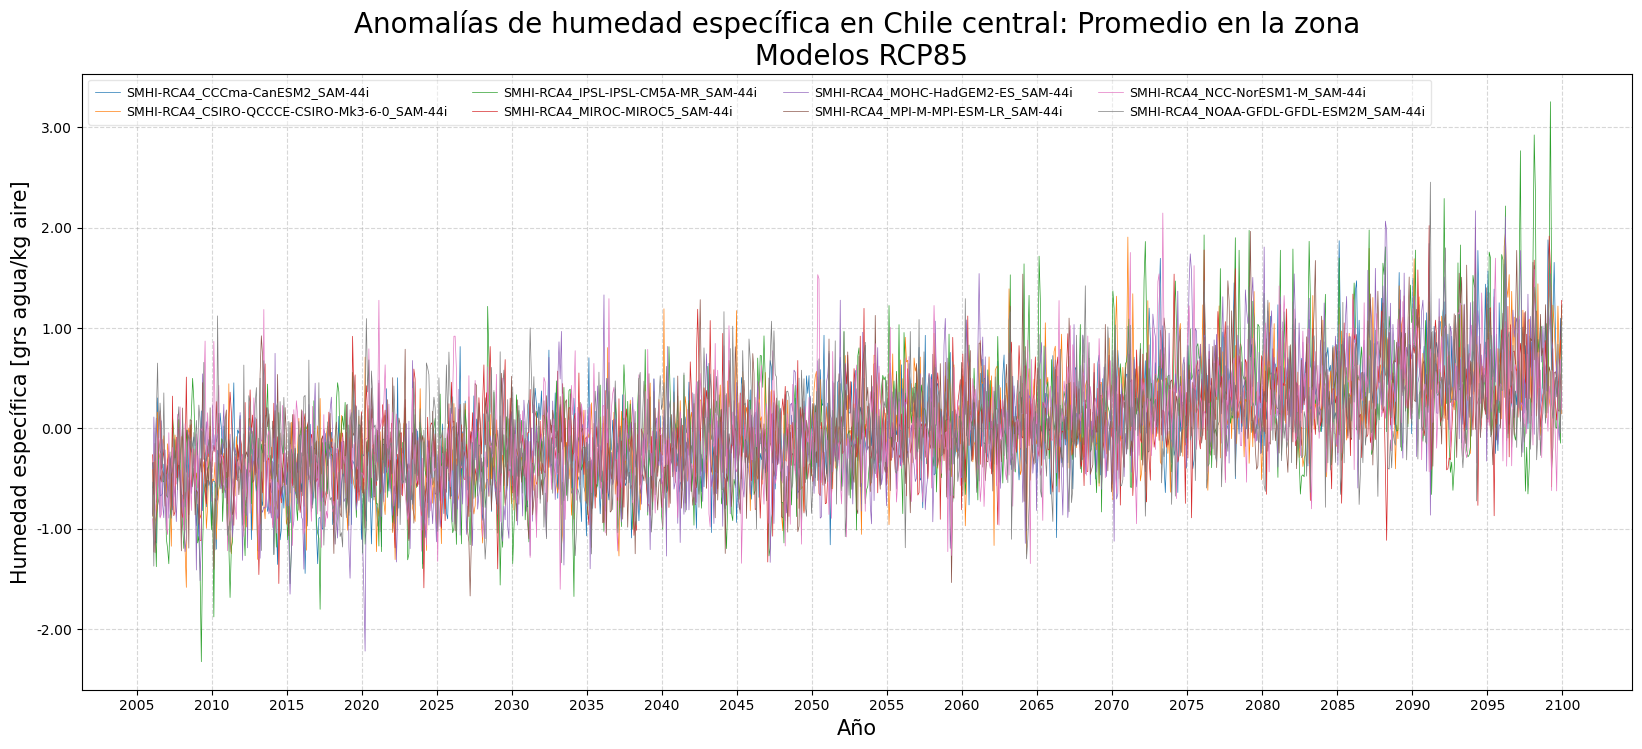

In [13]:
# Graficamos las series de tiempo de las anomalías de los modelos RCP85
fig, ax = plt.subplots(figsize=(20, 8))
for model in huss_rcp85_data_chile_central.keys():
    ax.plot(rh.cfdate2datetime(huss_rcp85_data_chile_central[model]['time']), huss_rcp85_data_chile_central[model]['anomaly_series'].mean(
        axis=(1, 2)), label=model, lw=0.5)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(kg2grams_formatter))
ax.set_title(
    'Anomalías de humedad específica en Chile central: Promedio en la zona\n Modelos RCP85', fontsize=20)
ax.set_xlabel('Año', fontsize=15)
ax.set_ylabel('Humedad específica [grs agua/kg aire]', fontsize=15)
ax.legend(ncol=4, fontsize=9, loc='upper left', handletextpad=0.5,
          handlelength=2, fancybox=True, framealpha=0.5, borderpad=0.5)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(5))
ax.grid(alpha=0.5, linestyle='--')
plt.show()


## Promedio Espacial entre Modelos


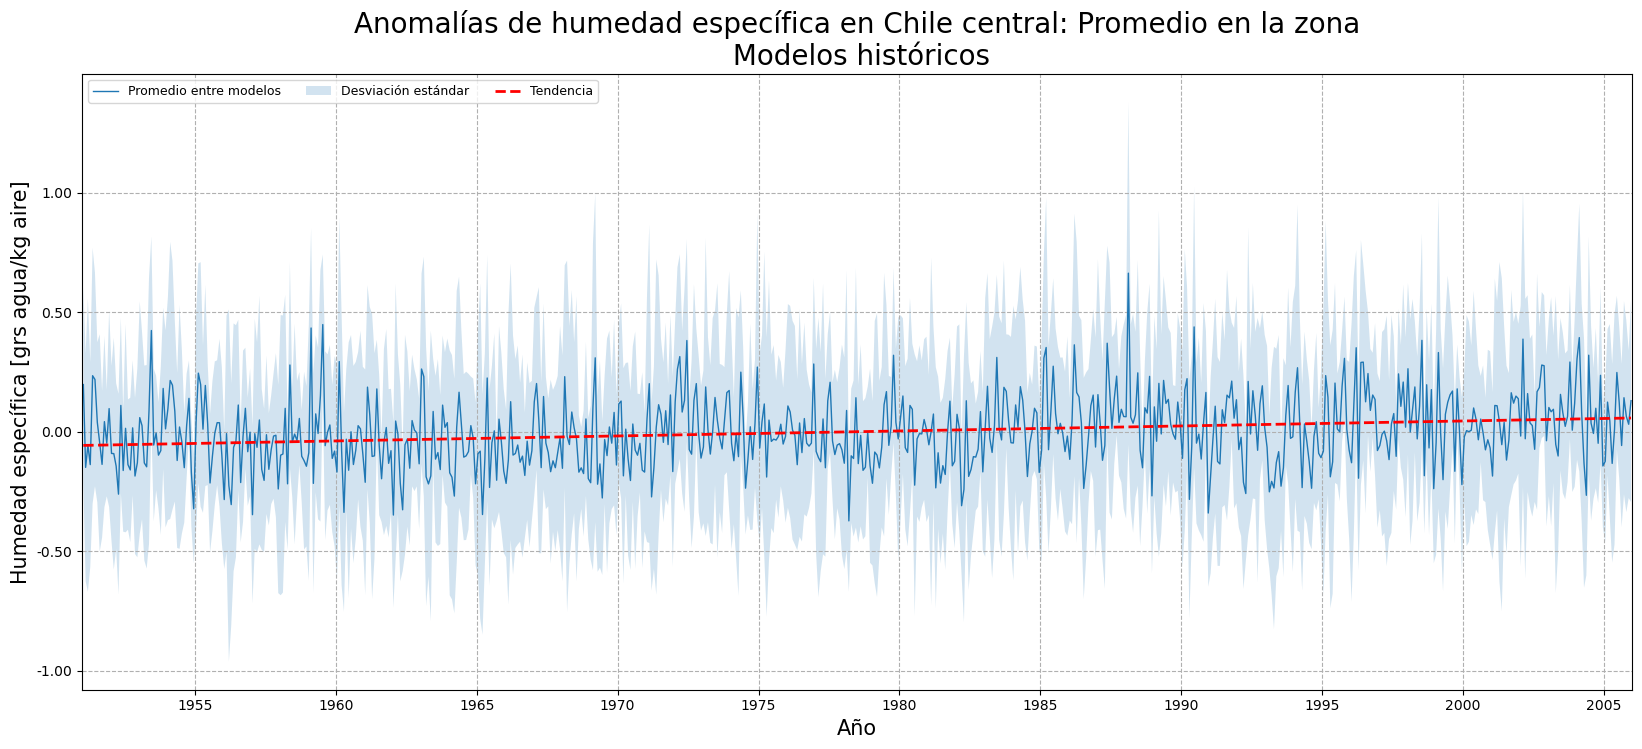

In [14]:
# Promediamos las series de tiempo de los distintos modelos históricos para obtener una serie de tiempo promedio, agregamos barras de error con la desviación estándar
huss_historical_data_chile_central_mean = np.zeros(huss_historical_data_chile_central[list(
    huss_historical_data_chile_central.keys())[0]]['anomaly_series'].shape)
for model in huss_historical_data_chile_central.keys():
    huss_historical_data_chile_central_mean += huss_historical_data_chile_central[model]['anomaly_series']
huss_historical_data_chile_central_mean /= len(
    huss_historical_data_chile_central.keys())
huss_historical_data_chile_central_std = np.std(
    [huss_historical_data_chile_central[model]['anomaly_series'] for model in huss_historical_data_chile_central.keys()], axis=0)

# Graficamos la serie de tiempo promedio de los modelos históricos
fig, ax = plt.subplots(figsize=(20, 8))
time_axis = rh.cfdate2datetime(huss_historical_data_chile_central[list(
    huss_historical_data_chile_central.keys())[0]]['time'])
ax.plot(time_axis, huss_historical_data_chile_central_mean.mean(
    axis=(1, 2)), label='Promedio entre modelos', lw=1)
ax.fill_between(time_axis, huss_historical_data_chile_central_mean.mean(axis=(1, 2)) - huss_historical_data_chile_central_std.mean(axis=(1, 2)),
                huss_historical_data_chile_central_mean.mean(axis=(1, 2)) + huss_historical_data_chile_central_std.mean(axis=(1, 2)), alpha=0.2, label='Desviación estándar')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(kg2grams_formatter))
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(5))
ax.set_xlim([datetime.datetime(1951, 1, 1), datetime.datetime(2005, 12, 31)])

# Añadimos una línea de tendencia
z = np.polyfit(matplotlib.dates.date2num(time_axis),
               huss_historical_data_chile_central_mean.mean(axis=(1, 2)), 1)
p = np.poly1d(z)
ax.plot(time_axis, p(matplotlib.dates.date2num(time_axis)),
        "r--", label='Tendencia', lw=2)

ax.set_title(
    'Anomalías de humedad específica en Chile central: Promedio en la zona\n Modelos históricos', fontsize=20)
ax.set_xlabel('Año', fontsize=15)
ax.set_ylabel('Humedad específica [grs agua/kg aire]', fontsize=15)
ax.legend(ncol=4, fontsize=9, loc='upper left')
ax.grid(True, which='both', axis='both', linestyle='--')
plt.show()


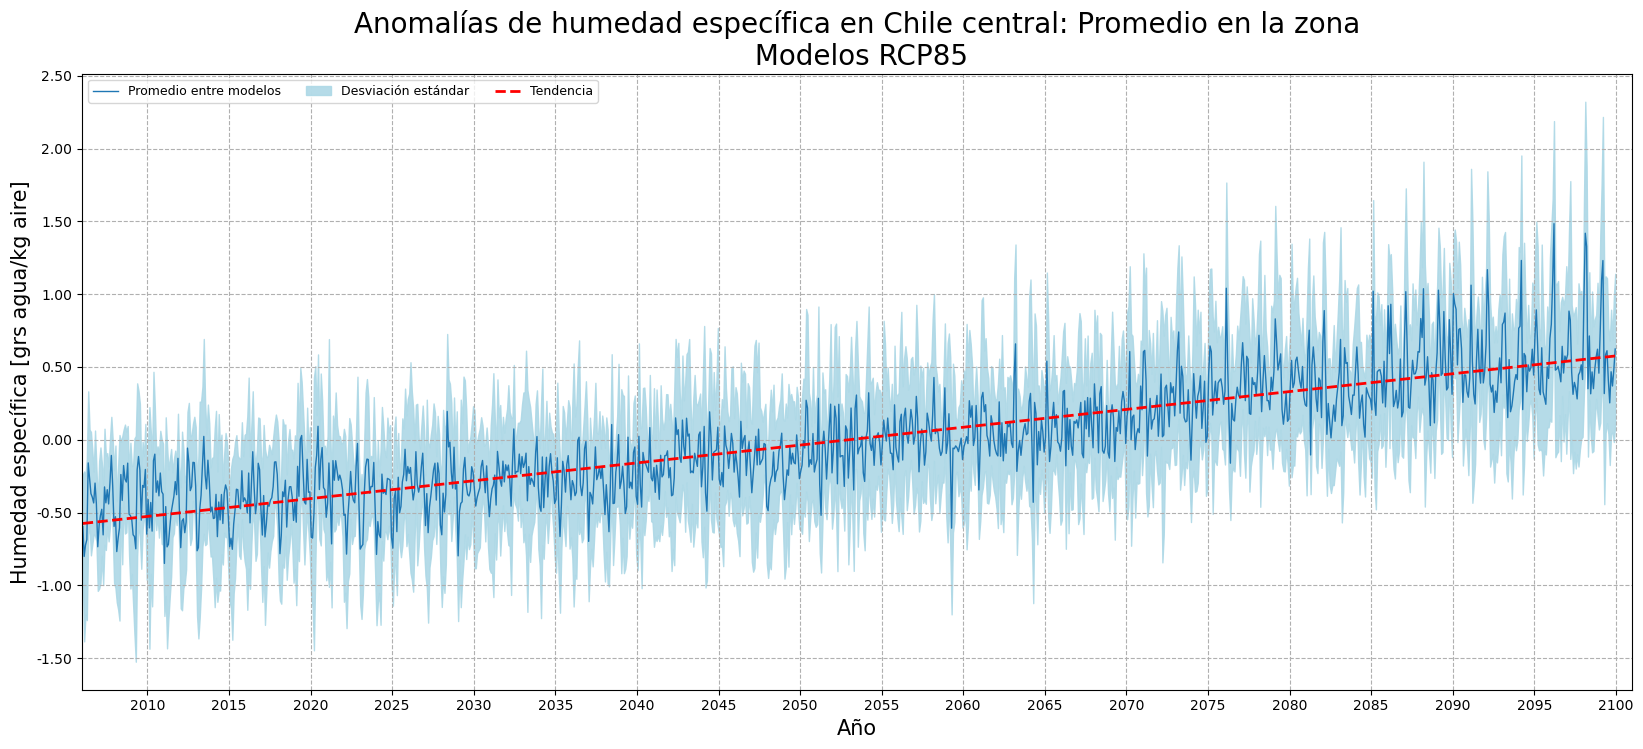

In [15]:
# Promediamos las series de tiempo de los distintos modelos RCP85 para obtener una serie de tiempo promedio, agregamos barras de error con la desviación estándar
huss_rcp85_data_chile_central_mean = np.zeros(huss_rcp85_data_chile_central[list(
    huss_rcp85_data_chile_central.keys())[0]]['anomaly_series'].shape)
for model in huss_rcp85_data_chile_central.keys():
    huss_rcp85_data_chile_central_mean += huss_rcp85_data_chile_central[model]['anomaly_series']
huss_rcp85_data_chile_central_mean /= len(huss_rcp85_data_chile_central.keys())
huss_rcp85_data_chile_central_std = np.std(
    [huss_rcp85_data_chile_central[model]['anomaly_series'] for model in huss_rcp85_data_chile_central.keys()], axis=0)

# Graficamos la serie de tiempo promedio de los modelos RCP85
fig, ax = plt.subplots(figsize=(20, 8))
time_axis = rh.cfdate2datetime(huss_rcp85_data_chile_central[list(
    huss_rcp85_data_chile_central.keys())[0]]['time'])
ax.plot(time_axis, huss_rcp85_data_chile_central_mean.mean(
    axis=(1, 2)), label='Promedio entre modelos', lw=1)
ax.fill_between(time_axis, huss_rcp85_data_chile_central_mean.mean(axis=(1, 2)) - huss_rcp85_data_chile_central_std.mean(axis=(1, 2)),
                huss_rcp85_data_chile_central_mean.mean(axis=(1, 2)) + huss_rcp85_data_chile_central_std.mean(axis=(1, 2)), alpha=0.9, label='Desviación estándar', color='lightblue')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(kg2grams_formatter))
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(5))
ax.set_xlim([datetime.datetime(2006, 1, 1), datetime.datetime(2100, 12, 31)])

# Añadimos una línea de tendencia
z = np.polyfit(matplotlib.dates.date2num(time_axis),
               huss_rcp85_data_chile_central_mean.mean(axis=(1, 2)), 1)
p = np.poly1d(z)
ax.plot(time_axis, p(matplotlib.dates.date2num(time_axis)),
        "r--", label='Tendencia', lw=2)

ax.set_title(
    'Anomalías de humedad específica en Chile central: Promedio en la zona\n Modelos RCP85', fontsize=20)
ax.set_xlabel('Año', fontsize=15)
ax.set_ylabel('Humedad específica [grs agua/kg aire]', fontsize=15)
ax.legend(ncol=4, fontsize=9, loc='upper left')
ax.grid(True, which='both', axis='both', linestyle='--')
plt.show()


In [16]:
huss_historical_data_chile_central_mean.mean(axis=0).shape

(10, 8)

## Promedio Temporal entre Modelos


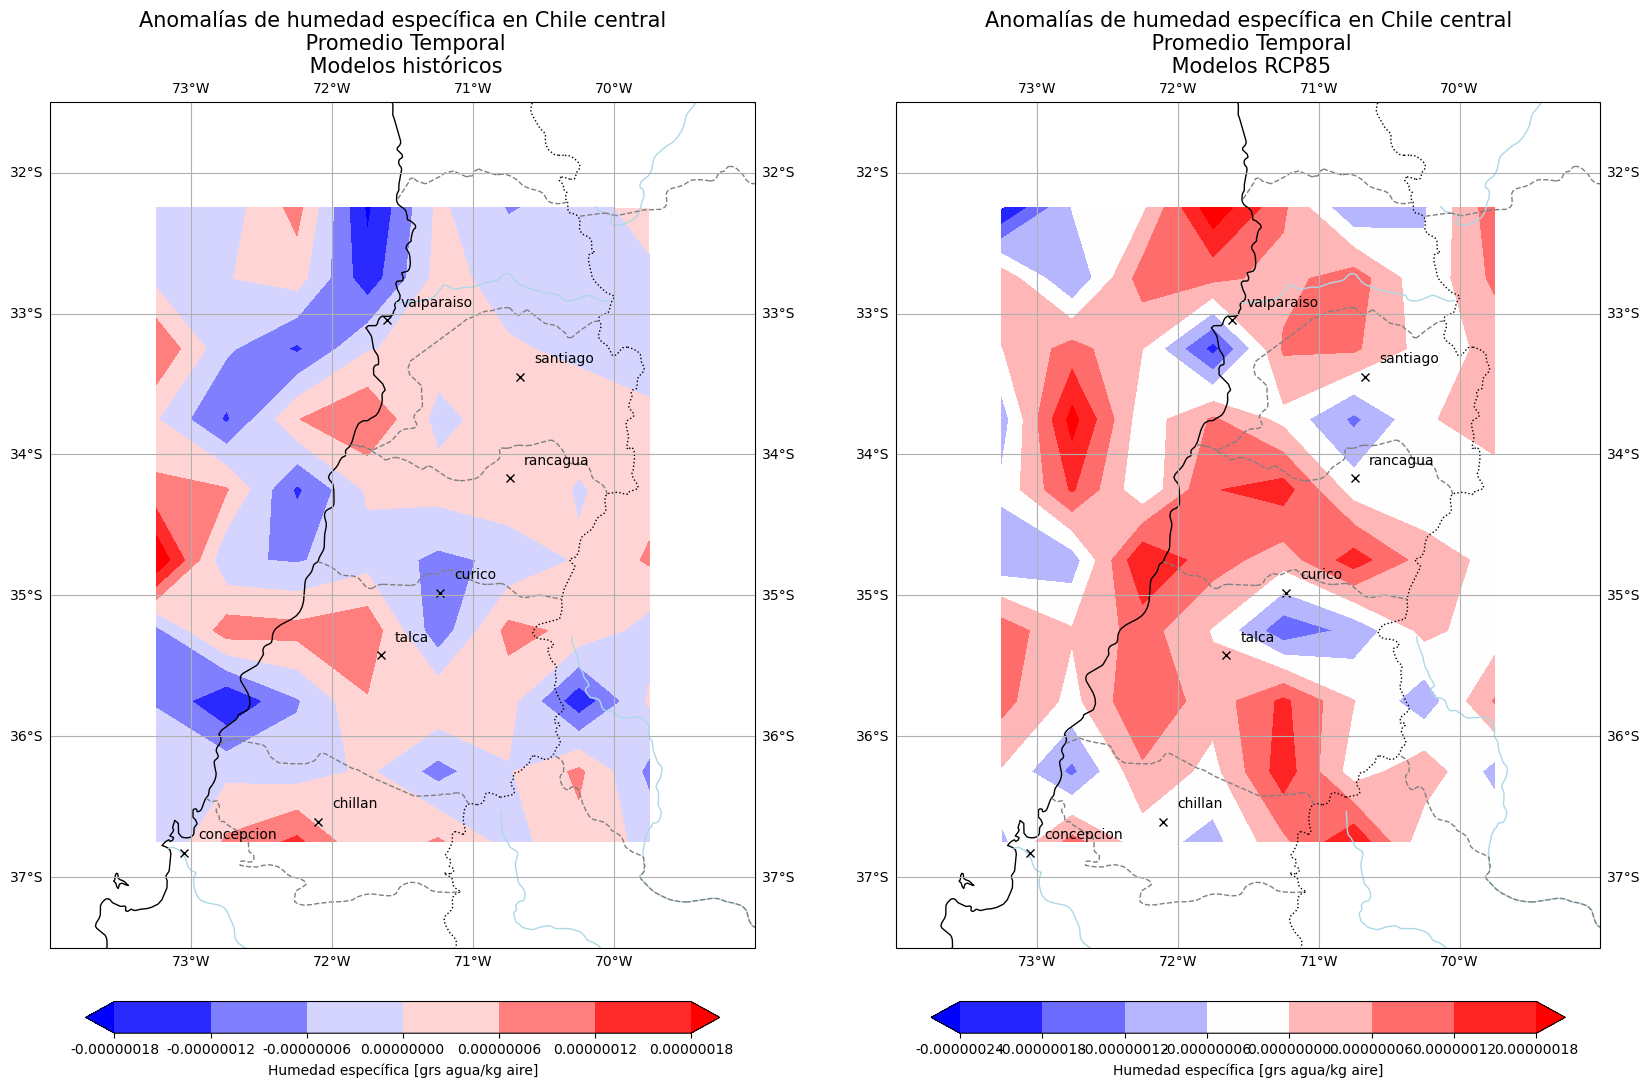

In [17]:
def kg2grams_formatter(x, pos):
    """
    Formatea un número en gramos.
    """
    return '{:.8f}'.format(x*1000)


# Graficamos en el mapa los modelos históricos y RCP85
# Usando huss_historical_data_chile_central_mean y huss_rcp85_data_chile_central_mean
data = [huss_historical_data_chile_central_mean,
        huss_rcp85_data_chile_central_mean]
map_mesh = np.meshgrid(lon_map, lat_map)
contour_levels = np.linspace(-0.0005, 0.0005, 40)
# contourf_kwargs = {'extend': 'both', 'transform': ccrs.PlateCarree(), 'cmap': 'bwr', 'levels': contour_levels}
contourf_kwargs = {'extend': 'both',
                   'transform': ccrs.PlateCarree(), 'cmap': 'bwr'}

fig, axs = plt.subplots(ncols=2, figsize=(
    20, 14), subplot_kw=dict(projection=ccrs.PlateCarree()))
for i, ax in enumerate(axs):
    ax.set_extent([chile_central_lon[0]-0.5, chile_central_lon[1]+0.5,
                  chile_central_lat[0]-0.5, chile_central_lat[1]+0.5], crs=ccrs.PlateCarree())
    ax.coastlines(resolution='10m')
    ax.add_feature(ccrs.cartopy.feature.BORDERS, linestyle=':')
    ax.add_feature(ccrs.cartopy.feature.LAKES, color='lightblue')
    ax.add_feature(ccrs.cartopy.feature.RIVERS, color='lightblue')
    ax.add_feature(states_provinces, edgecolor='gray')
    h = ax.contourf(lon_map, lat_map, data[i].mean(axis=0), **contourf_kwargs)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False,
                 y_inline=False, crs=ccrs.PlateCarree())
    # Añadimos las ciudades
    for city in cities.keys():
        ax.plot(cities[city][1], cities[city][0],
                transform=ccrs.PlateCarree(), marker='x', color='black')
        # text
        ax.text(cities[city][1] + 0.1, cities[city][0] +
                0.1, city, transform=ccrs.PlateCarree())
    # Añadimos la barra de colores horizontal
    cbar = plt.colorbar(h, ax=ax, orientation='horizontal',
                        shrink=0.9, pad=0.05)
    cbar.ax.set_xlabel('Humedad específica [grs agua/kg aire]', fontsize=10)
    # Aplicamos el formato de gramos
    cbar.ax.xaxis.set_major_formatter(
        mticker.FuncFormatter(kg2grams_formatter))
    # Añadimos el título
    ax.set_title('Anomalías de humedad específica en Chile central\n Promedio Temporal\n Modelos históricos' if i ==
                 0 else 'Anomalías de humedad específica en Chile central\n Promedio Temporal\n Modelos RCP85', fontsize=15)
plt.show()


In [18]:
data[0].shape


(660, 10, 8)

# Valores Totales


In [19]:
# Extraemos la información de los modelos históricos
huss_historical_data_total = {}

for model in huss_historical_datasets:
    model_name = model.model_id + '_' + \
        model.driving_model_id + '_' + model.CORDEX_domain
    huss_historical_data_total[model_name] = {}
    huss_historical_data_total[model_name]['lat'] = model['lat'][:]
    huss_historical_data_total[model_name]['lon'] = model['lon'][:]
    huss_historical_data_total[model_name]['time'] = cftime.num2date(
        model['time'][:], model['time'].units, calendar=model['time'].calendar)
    huss_historical_data_total[model_name]['time'] = rh.cfdate2datetime(
        huss_historical_data_total[model_name]['time'])
    huss_historical_data_total[model_name]['huss'] = model['huss'][:]
    huss_historical_data_total[model_name]['model_id'] = model.model_id
    huss_historical_data_total[model_name]['driving_model_id'] = model.driving_model_id
    huss_historical_data_total[model_name]['cordex_domain'] = model.CORDEX_domain


In [20]:
# Extraemos la información de los modelos RCP85
huss_rcp85_data_total = {}

for model in huss_rcp85_datasets:
    model_name = model.model_id + '_' + \
        model.driving_model_id + '_' + model.CORDEX_domain
    huss_rcp85_data_total[model_name] = {}
    huss_rcp85_data_total[model_name]['lat'] = model['lat'][:]
    huss_rcp85_data_total[model_name]['lon'] = model['lon'][:]
    huss_rcp85_data_total[model_name]['time'] = cftime.num2date(
        model['time'][:], model['time'].units, calendar=model['time'].calendar)
    huss_rcp85_data_total[model_name]['time'] = rh.cfdate2datetime(
        huss_rcp85_data_total[model_name]['time'])
    # Limitamos los datos hasta 2099-12-31
    time_idx = np.where(
        huss_rcp85_data_total[model_name]['time'] <= datetime.datetime(2099, 12, 31))[0]
    huss_rcp85_data_total[model_name]['time'] = huss_rcp85_data_total[model_name]['time'][time_idx]
    huss_rcp85_data_total[model_name]['huss'] = model['huss'][:]
    huss_rcp85_data_total[model_name]['huss'] = huss_rcp85_data_total[model_name]['huss'][time_idx, :, :]
    huss_rcp85_data_total[model_name]['model_id'] = model.model_id
    huss_rcp85_data_total[model_name]['driving_model_id'] = model.driving_model_id
    huss_rcp85_data_total[model_name]['cordex_domain'] = model.CORDEX_domain


In [21]:
# Filtramos los datos históricos segun los límites de Chile central

# Definimos los límites de Chile central
chile_central_lat = (-37, -32)
# chile_central_lon = (360 - 73, 360 - 71)
chile_central_lon = (-73.5, -69.5)

print('Filtrando datos históricos...')
for model in huss_historical_data_total.keys():
    # Obtenemos los índices de las latitudes y longitudes de Chile central
    lat_index = np.where((huss_historical_data_total[model]['lat'] >= chile_central_lat[0]) & (
        huss_historical_data_total[model]['lat'] <= chile_central_lat[1]))[0]
    lon_index = np.where((huss_historical_data_total[model]['lon'] >= chile_central_lon[0]) & (
        huss_historical_data_total[model]['lon'] <= chile_central_lon[1]))[0]
    # Filtramos las latitudes y longitudes de Chile central
    huss_historical_data_total[model]['lat'] = huss_historical_data_total[model]['lat'][lat_index]
    huss_historical_data_total[model]['lon'] = huss_historical_data_total[model]['lon'][lon_index]
    # Filtramos las anomalías de Chile central
    huss_historical_data_total[model]['huss'] = huss_historical_data_total[model]['huss'][:,
                                                                                          lat_index, :][:, :, lon_index]
    print(f'Filtro geográfico aplicado para {model}.')


Filtrando datos históricos...
Filtro geográfico aplicado para SMHI-RCA4_CCCma-CanESM2_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_CSIRO-QCCCE-CSIRO-Mk3-6-0_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_IPSL-IPSL-CM5A-MR_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_MIROC-MIROC5_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_MOHC-HadGEM2-ES_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_MPI-M-MPI-ESM-LR_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_NCC-NorESM1-M_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_NOAA-GFDL-GFDL-ESM2M_SAM-44i.


In [22]:
# Filtramos los datos RCP85 segun los límites de Chile central

print('Filtrando datos RCP85...')
for model in huss_rcp85_data_total.keys():
    # Obtenemos los índices de las latitudes y longitudes de Chile central
    lat_index = np.where((huss_rcp85_data_total[model]['lat'] >= chile_central_lat[0]) & (
        huss_rcp85_data_total[model]['lat'] <= chile_central_lat[1]))[0]
    lon_index = np.where((huss_rcp85_data_total[model]['lon'] >= chile_central_lon[0]) & (
        huss_rcp85_data_total[model]['lon'] <= chile_central_lon[1]))[0]
    # Filtramos las latitudes y longitudes de Chile central
    huss_rcp85_data_total[model]['lat'] = huss_rcp85_data_total[model]['lat'][lat_index]
    huss_rcp85_data_total[model]['lon'] = huss_rcp85_data_total[model]['lon'][lon_index]
    # Filtramos las anomalías de Chile central
    huss_rcp85_data_total[model]['huss'] = huss_rcp85_data_total[model]['huss'][:,
                                                                                lat_index, :][:, :, lon_index]
    print(f'Filtro geográfico aplicado para {model}.')


Filtrando datos RCP85...
Filtro geográfico aplicado para SMHI-RCA4_CCCma-CanESM2_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_CSIRO-QCCCE-CSIRO-Mk3-6-0_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_IPSL-IPSL-CM5A-MR_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_MIROC-MIROC5_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_MOHC-HadGEM2-ES_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_MPI-M-MPI-ESM-LR_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_NCC-NorESM1-M_SAM-44i.
Filtro geográfico aplicado para SMHI-RCA4_NOAA-GFDL-GFDL-ESM2M_SAM-44i.


## Promedio Espacial por Modelo


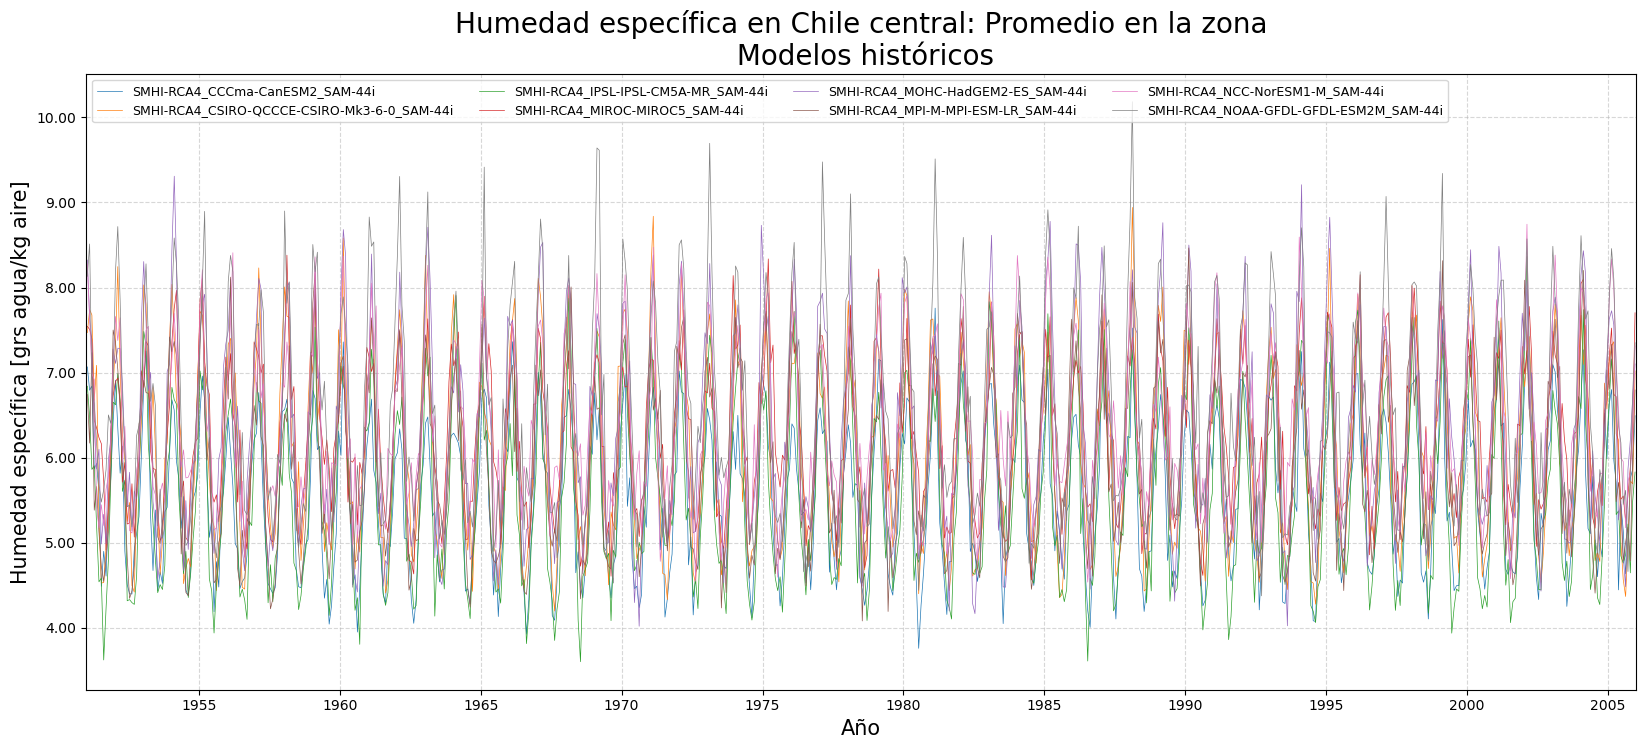

In [23]:
def kg2grams_formatter(x, pos):
    """
    Formatea un número en gramos.
    """
    return '{:.2f}'.format(x*1000)


# Graficamos las series de tiempo de las anomalías de los modelos históricos
fig, ax = plt.subplots(figsize=(20, 8))
for model in huss_historical_data_total.keys():
    ax.plot(huss_historical_data_total[model]['time'], huss_historical_data_total[model]['huss'].mean(
        axis=(1, 2)), label=model, lw=0.5)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(kg2grams_formatter))
ax.set_title(
    'Humedad específica en Chile central: Promedio en la zona\n Modelos históricos', fontsize=20)
ax.set_xlabel('Año', fontsize=15)
ax.set_ylabel('Humedad específica [grs agua/kg aire]', fontsize=15)
ax.legend(ncol=4, fontsize=9, loc='upper left')
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(5))
ax.set_xlim([datetime.datetime(1951, 1, 1), datetime.datetime(2005, 12, 31)])
ax.grid(alpha=0.5, linestyle='--')
plt.show()


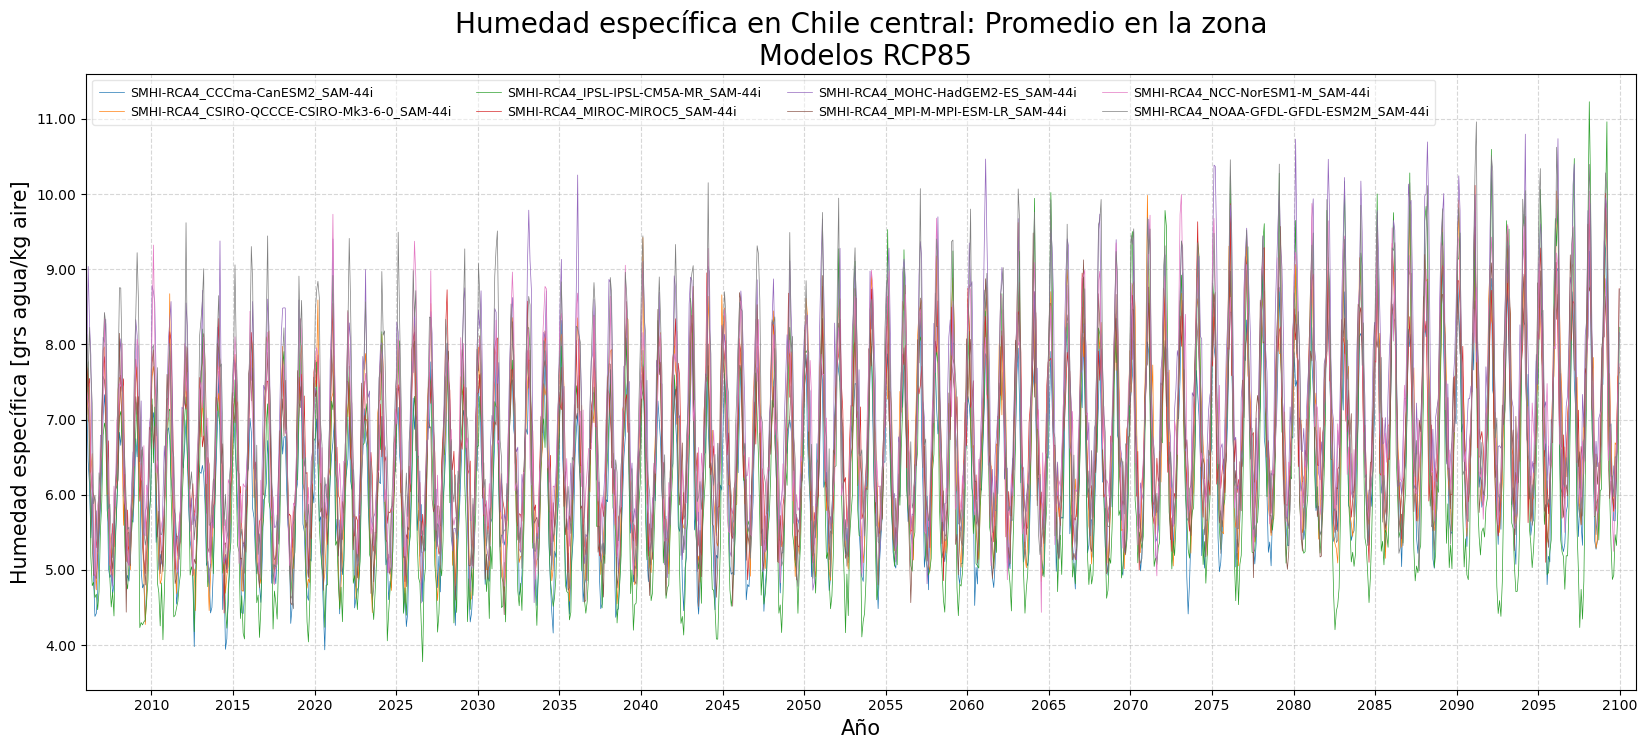

In [24]:
# Graficamos las series de tiempo de las anomalías de los modelos RCP85
fig, ax = plt.subplots(figsize=(20, 8))
for model in huss_rcp85_data_total.keys():
    ax.plot(huss_rcp85_data_total[model]['time'], huss_rcp85_data_total[model]['huss'].mean(
        axis=(1, 2)), label=model, lw=0.5)
ax.yaxis.set_major_formatter(mticker.FuncFormatter(kg2grams_formatter))
ax.set_title(
    'Humedad específica en Chile central: Promedio en la zona\n Modelos RCP85', fontsize=20)
ax.set_xlabel('Año', fontsize=15)
ax.set_ylabel('Humedad específica [grs agua/kg aire]', fontsize=15)
ax.legend(ncol=4, fontsize=9, loc='upper left', handletextpad=0.5,
          handlelength=2, fancybox=True, framealpha=0.5, borderpad=0.5)
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(5))
ax.set_xlim([datetime.datetime(2006, 1, 1), datetime.datetime(2100, 12, 31)])
ax.grid(alpha=0.5, linestyle='--')
plt.show()


## Promedio Espacial entre Modelos


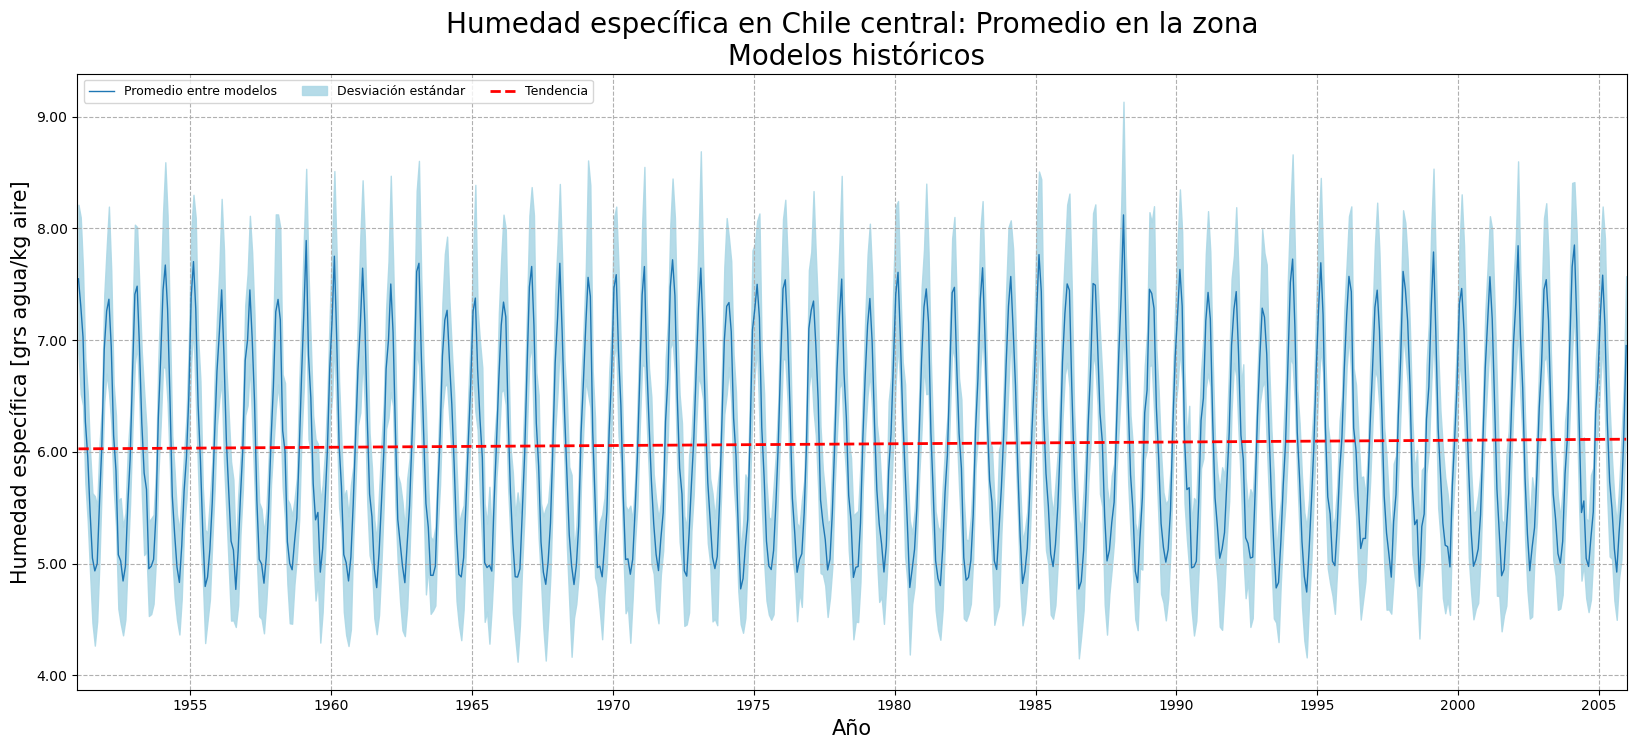

In [25]:
# Promediamos las series de tiempo de los distintos modelos históricos para obtener una serie de tiempo promedio, agregamos barras de error con la desviación estándar
huss_historical_data_total_mean = np.zeros(huss_historical_data_total[list(
    huss_historical_data_total.keys())[0]]['huss'].shape)
for model in huss_historical_data_total.keys():
    huss_historical_data_total_mean += huss_historical_data_total[model]['huss']
huss_historical_data_total_mean /= len(huss_historical_data_total.keys())
huss_historical_data_total_std = np.std(
    [huss_historical_data_total[model]['huss'] for model in huss_historical_data_total.keys()], axis=0)

# Graficamos la serie de tiempo promedio de los modelos históricos
fig, ax = plt.subplots(figsize=(20, 8))
time_axis = huss_historical_data_total[list(
    huss_historical_data_total.keys())[0]]['time']
ax.plot(time_axis, huss_historical_data_total_mean.mean(
    axis=(1, 2)), label='Promedio entre modelos', lw=1)
ax.fill_between(time_axis, huss_historical_data_total_mean.mean(axis=(1, 2)) - huss_historical_data_total_std.mean(axis=(1, 2)),
                huss_historical_data_total_mean.mean(axis=(1, 2)) + huss_historical_data_total_std.mean(axis=(1, 2)), alpha=0.9, label='Desviación estándar', color='lightblue')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(kg2grams_formatter))
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(5))
ax.set_xlim([datetime.datetime(1951, 1, 1), datetime.datetime(2005, 12, 31)])

# Añadimos una línea de tendencia
z = np.polyfit(matplotlib.dates.date2num(time_axis),
               huss_historical_data_total_mean.mean(axis=(1, 2)), 1)
p = np.poly1d(z)
ax.plot(time_axis, p(matplotlib.dates.date2num(time_axis)),
        "r--", label='Tendencia', lw=2)

ax.set_title(
    'Humedad específica en Chile central: Promedio en la zona\n Modelos históricos', fontsize=20)
ax.set_xlabel('Año', fontsize=15)
ax.set_ylabel('Humedad específica [grs agua/kg aire]', fontsize=15)
ax.legend(ncol=4, fontsize=9, loc='upper left')
ax.grid(True, which='both', axis='both', linestyle='--')
plt.show()


In [26]:
# Mostramos las fechas iniciales y finales de cada modelo rcp85
for model in huss_rcp85_data_total.keys():
    print('{:45s}: {} - {}'.format(model,
          huss_rcp85_data_total[model]['time'][0], huss_rcp85_data_total[model]['time'][-1]))


SMHI-RCA4_CCCma-CanESM2_SAM-44i              : 2006-01-16 12:00:00 - 2099-12-16 12:00:00
SMHI-RCA4_CSIRO-QCCCE-CSIRO-Mk3-6-0_SAM-44i  : 2006-01-16 12:00:00 - 2099-12-16 12:00:00
SMHI-RCA4_IPSL-IPSL-CM5A-MR_SAM-44i          : 2006-01-16 12:00:00 - 2099-12-16 12:00:00
SMHI-RCA4_MIROC-MIROC5_SAM-44i               : 2006-01-16 12:00:00 - 2099-12-16 12:00:00
SMHI-RCA4_MOHC-HadGEM2-ES_SAM-44i            : 2006-01-16 00:00:00 - 2099-12-16 00:00:00
SMHI-RCA4_MPI-M-MPI-ESM-LR_SAM-44i           : 2006-01-16 12:00:00 - 2099-12-16 12:00:00
SMHI-RCA4_NCC-NorESM1-M_SAM-44i              : 2006-01-16 12:00:00 - 2099-12-16 12:00:00
SMHI-RCA4_NOAA-GFDL-GFDL-ESM2M_SAM-44i       : 2006-01-16 12:00:00 - 2099-12-16 12:00:00


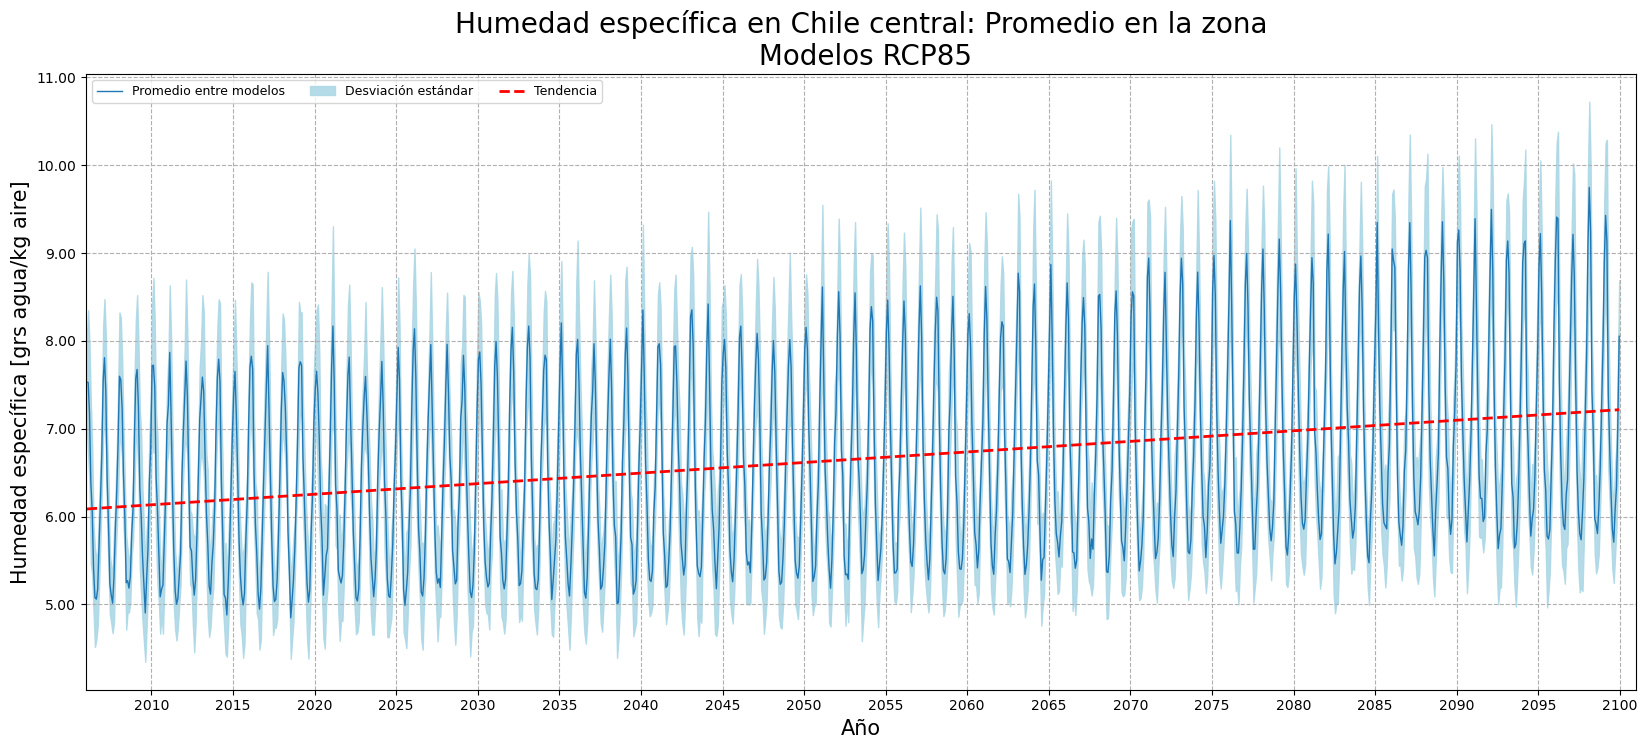

In [27]:
# Promediamos las series de tiempo de los distintos modelos RCP85 para obtener una serie de tiempo promedio, agregamos barras de error con la desviación estándar
huss_rcp85_data_total_mean = np.zeros(
    huss_rcp85_data_total[list(huss_rcp85_data_total.keys())[0]]['huss'].shape)
for model in huss_rcp85_data_total.keys():
    huss_rcp85_data_total_mean += huss_rcp85_data_total[model]['huss']
huss_rcp85_data_total_mean /= len(huss_rcp85_data_total.keys())
huss_rcp85_data_total_std = np.std(
    [huss_rcp85_data_total[model]['huss'] for model in huss_rcp85_data_total.keys()], axis=0)

# Graficamos la serie de tiempo promedio de los modelos RCP85
fig, ax = plt.subplots(figsize=(20, 8))
time_axis = huss_rcp85_data_total[list(
    huss_rcp85_data_total.keys())[0]]['time']
ax.plot(time_axis, huss_rcp85_data_total_mean.mean(
    axis=(1, 2)), label='Promedio entre modelos', lw=1)
ax.fill_between(time_axis, huss_rcp85_data_total_mean.mean(axis=(1, 2)) - huss_rcp85_data_total_std.mean(axis=(1, 2)),
                huss_rcp85_data_total_mean.mean(axis=(1, 2)) + huss_rcp85_data_total_std.mean(axis=(1, 2)), alpha=0.9, label='Desviación estándar', color='lightblue')
ax.yaxis.set_major_formatter(mticker.FuncFormatter(kg2grams_formatter))
ax.xaxis.set_major_locator(matplotlib.dates.YearLocator(5))
ax.set_xlim([datetime.datetime(2006, 1, 1), datetime.datetime(2100, 12, 31)])

# Añadimos una línea de tendencia
z = np.polyfit(matplotlib.dates.date2num(time_axis),
               huss_rcp85_data_total_mean.mean(axis=(1, 2)), 1)
p = np.poly1d(z)
ax.plot(time_axis, p(matplotlib.dates.date2num(time_axis)),
        "r--", label='Tendencia', lw=2)

ax.set_title(
    'Humedad específica en Chile central: Promedio en la zona\n Modelos RCP85', fontsize=20)
ax.set_xlabel('Año', fontsize=15)
ax.set_ylabel('Humedad específica [grs agua/kg aire]', fontsize=15)
ax.legend(ncol=4, fontsize=9, loc='upper left')
ax.grid(True, which='both', axis='both', linestyle='--')
plt.show()


In [28]:
# Guardamos el rango de tiempo de los datos históricos (valor mínimo y máximo)
huss_historical_data_total_time_range = (huss_historical_data_total[list(huss_historical_data_total.keys(
))[0]]['time'][0], huss_historical_data_total[list(huss_historical_data_total.keys())[0]]['time'][-1])
# Guardamos el rango de tiempo de los datos RCP85 (valor mínimo y máximo)
huss_rcp85_data_total_time_range = (huss_rcp85_data_total[list(huss_rcp85_data_total.keys())[
                                    0]]['time'][0], huss_rcp85_data_total[list(huss_rcp85_data_total.keys())[0]]['time'][-1])

# Imprimimos los rangos de tiempo únicamente en formato de año, indicando el año inicial, final y el rango de años
print('Rango de tiempo de los datos históricos:'.ljust(50, ' ') + '{} - {} ({} años)'.format(
    huss_historical_data_total_time_range[0].year, huss_historical_data_total_time_range[1].year, huss_historical_data_total_time_range[1].year - huss_historical_data_total_time_range[0].year + 1))
print('Rango de tiempo de los datos RCP85:'.ljust(50, ' ') + '{} - {} ({} años)'.format(
    huss_rcp85_data_total_time_range[0].year, huss_rcp85_data_total_time_range[1].year, huss_rcp85_data_total_time_range[1].year - huss_rcp85_data_total_time_range[0].year + 1))

# Definimos los dos intervalos de tiempo para los datos historicos definiendo los años que queremos
year_time_range_historical_1 = (datetime.datetime(
    1951, 1, 1), datetime.datetime(1976, 1, 1))
year_time_range_historical_2 = (datetime.datetime(
    1980, 1, 1), datetime.datetime(2005, 1, 1))

# Definimos los dos intervalos de tiempo para los datos RCP85 definiendo los años que queremos
year_time_range_rcp85_1 = (datetime.datetime(
    2020, 1, 1), datetime.datetime(2045, 1, 1))
year_time_range_rcp85_2 = (datetime.datetime(
    2060, 1, 1), datetime.datetime(2085, 1, 1))

# Impriimimos los rangos de tiempo en formato de año
print('Rango de tiempo 1 de los datos históricos:'.ljust(50, ' ') + '{} - {} ({} años)'.format(
    year_time_range_historical_1[0].year, year_time_range_historical_1[1].year, year_time_range_historical_1[1].year - year_time_range_historical_1[0].year))
print('Rango de tiempo 2 de los datos históricos:'.ljust(50, ' ') + '{} - {} ({} años)'.format(
    year_time_range_historical_2[0].year, year_time_range_historical_2[1].year, year_time_range_historical_2[1].year - year_time_range_historical_2[0].year))
print('Rango de tiempo 1 de los datos RCP85:'.ljust(50, ' ') + '{} - {} ({} años)'.format(
    year_time_range_rcp85_1[0].year, year_time_range_rcp85_1[1].year, year_time_range_rcp85_1[1].year - year_time_range_rcp85_1[0].year))
print('Rango de tiempo 2 de los datos RCP85:'.ljust(50, ' ') + '{} - {} ({} años)'.format(
    year_time_range_rcp85_2[0].year, year_time_range_rcp85_2[1].year, year_time_range_rcp85_2[1].year - year_time_range_rcp85_2[0].year))


Rango de tiempo de los datos históricos:          1951 - 2005 (55 años)
Rango de tiempo de los datos RCP85:               2006 - 2099 (94 años)
Rango de tiempo 1 de los datos históricos:        1951 - 1976 (25 años)
Rango de tiempo 2 de los datos históricos:        1980 - 2005 (25 años)
Rango de tiempo 1 de los datos RCP85:             2020 - 2045 (25 años)
Rango de tiempo 2 de los datos RCP85:             2060 - 2085 (25 años)


## Promedio Temporal entre Modelos, segmentamos por 2 periodos


In [29]:
# Creamos las segmentaciones de los datos históricos
huss_historical_data_total_segmentation_1 = {}
huss_historical_data_total_segmentation_2 = {}

for model in tqdm(huss_historical_datasets):
    model_name = model.model_id + '_' + \
        model.driving_model_id + '_' + model.CORDEX_domain

    # Creamos los diccionarios para cada modelo y segmento
    huss_historical_data_total_segmentation_1[model_name] = {}
    huss_historical_data_total_segmentation_2[model_name] = {}

    # Raw data
    huss_historical_data_total_segmentation_1[model_name]['lat'] = model['lat'][:]
    huss_historical_data_total_segmentation_1[model_name]['lon'] = model['lon'][:]
    huss_historical_data_total_segmentation_1[model_name]['huss'] = model['huss'][:]
    huss_historical_data_total_segmentation_1[model_name]['time'] = rh.cfdate2datetime(cftime.num2date(
        model['time'][:], model['time'].units, calendar=model['time'].calendar))
    huss_historical_data_total_segmentation_1[model_name]['model_id'] = model.model_id
    huss_historical_data_total_segmentation_1[model_name]['driving_model_id'] = model.driving_model_id
    huss_historical_data_total_segmentation_1[model_name]['cordex_domain'] = model.CORDEX_domain

    huss_historical_data_total_segmentation_2[model_name]['lat'] = model['lat'][:]
    huss_historical_data_total_segmentation_2[model_name]['lon'] = model['lon'][:]
    huss_historical_data_total_segmentation_2[model_name]['huss'] = model['huss'][:]
    huss_historical_data_total_segmentation_2[model_name]['time'] = rh.cfdate2datetime(cftime.num2date(
        model['time'][:], model['time'].units, calendar=model['time'].calendar))
    huss_historical_data_total_segmentation_2[model_name]['model_id'] = model.model_id
    huss_historical_data_total_segmentation_2[model_name]['driving_model_id'] = model.driving_model_id
    huss_historical_data_total_segmentation_2[model_name]['cordex_domain'] = model.CORDEX_domain

    # Filtros
    lat_index = np.where((huss_historical_data_total_segmentation_1[model_name]['lat'] >= chile_central_lat[0]) & (
        huss_historical_data_total_segmentation_1[model_name]['lat'] <= chile_central_lat[1]))[0]
    lon_index = np.where((huss_historical_data_total_segmentation_1[model_name]['lon'] >= chile_central_lon[0]) & (
        huss_historical_data_total_segmentation_1[model_name]['lon'] <= chile_central_lon[1]))[0]
    time_index_s1 = np.where((huss_historical_data_total_segmentation_1[model_name]['time'] >= year_time_range_historical_1[0]) & (
        huss_historical_data_total_segmentation_1[model_name]['time'] < year_time_range_historical_1[1]))[0]
    time_index_s2 = np.where((huss_historical_data_total_segmentation_1[model_name]['time'] >= year_time_range_historical_2[0]) & (
        huss_historical_data_total_segmentation_1[model_name]['time'] < year_time_range_historical_2[1]))[0]

    # Aplicamos los filtros
    huss_historical_data_total_segmentation_1[model_name][
        'lat'] = huss_historical_data_total_segmentation_1[model_name]['lat'][lat_index]
    huss_historical_data_total_segmentation_1[model_name][
        'lon'] = huss_historical_data_total_segmentation_1[model_name]['lon'][lon_index]
    huss_historical_data_total_segmentation_1[model_name]['huss'] = huss_historical_data_total_segmentation_1[
        model_name]['huss'][time_index_s1, :, :][:, lat_index, :][:, :, lon_index]
    huss_historical_data_total_segmentation_1[model_name][
        'time'] = huss_historical_data_total_segmentation_1[model_name]['time'][time_index_s1]

    huss_historical_data_total_segmentation_2[model_name][
        'lat'] = huss_historical_data_total_segmentation_2[model_name]['lat'][lat_index]
    huss_historical_data_total_segmentation_2[model_name][
        'lon'] = huss_historical_data_total_segmentation_2[model_name]['lon'][lon_index]
    huss_historical_data_total_segmentation_2[model_name]['huss'] = huss_historical_data_total_segmentation_2[
        model_name]['huss'][time_index_s2, :, :][:, lat_index, :][:, :, lon_index]
    huss_historical_data_total_segmentation_2[model_name][
        'time'] = huss_historical_data_total_segmentation_2[model_name]['time'][time_index_s2]

    # Calculamos los promedios espaciales y temporales
    huss_historical_data_total_segmentation_1[model_name]['huss_spatial_mean'] = huss_historical_data_total_segmentation_1[model_name]['huss'].mean(
        axis=(1, 2))
    huss_historical_data_total_segmentation_1[model_name]['huss_temporal_mean'] = huss_historical_data_total_segmentation_1[model_name]['huss'].mean(
        axis=(0))

    huss_historical_data_total_segmentation_2[model_name]['huss_spatial_mean'] = huss_historical_data_total_segmentation_2[model_name]['huss'].mean(
        axis=(1, 2))
    huss_historical_data_total_segmentation_2[model_name]['huss_temporal_mean'] = huss_historical_data_total_segmentation_2[model_name]['huss'].mean(
        axis=(0))


  0%|          | 0/8 [00:00<?, ?it/s]

In [30]:
# Creamos las segmentaciones de los datos RCP85
huss_rcp85_data_total_segmentation_1 = {}
huss_rcp85_data_total_segmentation_2 = {}

for model in tqdm(huss_rcp85_datasets):
    model_name = model.model_id + '_' + \
        model.driving_model_id + '_' + model.CORDEX_domain

    # Creamos los diccionarios para cada modelo y segmento
    huss_rcp85_data_total_segmentation_1[model_name] = {}
    huss_rcp85_data_total_segmentation_2[model_name] = {}

    # Raw data
    huss_rcp85_data_total_segmentation_1[model_name]['lat'] = model['lat'][:]
    huss_rcp85_data_total_segmentation_1[model_name]['lon'] = model['lon'][:]
    huss_rcp85_data_total_segmentation_1[model_name]['huss'] = model['huss'][:]
    huss_rcp85_data_total_segmentation_1[model_name]['time'] = rh.cfdate2datetime(cftime.num2date(
        model['time'][:], model['time'].units, calendar=model['time'].calendar))
    huss_rcp85_data_total_segmentation_1[model_name]['model_id'] = model.model_id
    huss_rcp85_data_total_segmentation_1[model_name]['driving_model_id'] = model.driving_model_id
    huss_rcp85_data_total_segmentation_1[model_name]['cordex_domain'] = model.CORDEX_domain

    huss_rcp85_data_total_segmentation_2[model_name]['lat'] = model['lat'][:]
    huss_rcp85_data_total_segmentation_2[model_name]['lon'] = model['lon'][:]
    huss_rcp85_data_total_segmentation_2[model_name]['huss'] = model['huss'][:]
    huss_rcp85_data_total_segmentation_2[model_name]['time'] = rh.cfdate2datetime(cftime.num2date(
        model['time'][:], model['time'].units, calendar=model['time'].calendar))
    huss_rcp85_data_total_segmentation_2[model_name]['model_id'] = model.model_id
    huss_rcp85_data_total_segmentation_2[model_name]['driving_model_id'] = model.driving_model_id
    huss_rcp85_data_total_segmentation_2[model_name]['cordex_domain'] = model.CORDEX_domain

    # Filtros
    lat_index = np.where((huss_rcp85_data_total_segmentation_1[model_name]['lat'] >= chile_central_lat[0]) & (
        huss_rcp85_data_total_segmentation_1[model_name]['lat'] <= chile_central_lat[1]))[0]
    lon_index = np.where((huss_rcp85_data_total_segmentation_1[model_name]['lon'] >= chile_central_lon[0]) & (
        huss_rcp85_data_total_segmentation_1[model_name]['lon'] <= chile_central_lon[1]))[0]
    time_index_s1 = np.where((huss_rcp85_data_total_segmentation_1[model_name]['time'] >= year_time_range_rcp85_1[0]) & (
        huss_rcp85_data_total_segmentation_1[model_name]['time'] < year_time_range_rcp85_1[1]))[0]
    time_index_s2 = np.where((huss_rcp85_data_total_segmentation_1[model_name]['time'] >= year_time_range_rcp85_2[0]) & (
        huss_rcp85_data_total_segmentation_1[model_name]['time'] < year_time_range_rcp85_2[1]))[0]

    # Aplicamos los filtros
    huss_rcp85_data_total_segmentation_1[model_name][
        'lat'] = huss_rcp85_data_total_segmentation_1[model_name]['lat'][lat_index]
    huss_rcp85_data_total_segmentation_1[model_name][
        'lon'] = huss_rcp85_data_total_segmentation_1[model_name]['lon'][lon_index]
    huss_rcp85_data_total_segmentation_1[model_name]['huss'] = huss_rcp85_data_total_segmentation_1[
        model_name]['huss'][time_index_s1, :, :][:, lat_index, :][:, :, lon_index]
    huss_rcp85_data_total_segmentation_1[model_name][
        'time'] = huss_rcp85_data_total_segmentation_1[model_name]['time'][time_index_s1]

    huss_rcp85_data_total_segmentation_2[model_name][
        'lat'] = huss_rcp85_data_total_segmentation_2[model_name]['lat'][lat_index]
    huss_rcp85_data_total_segmentation_2[model_name][
        'lon'] = huss_rcp85_data_total_segmentation_2[model_name]['lon'][lon_index]
    huss_rcp85_data_total_segmentation_2[model_name]['huss'] = huss_rcp85_data_total_segmentation_2[
        model_name]['huss'][time_index_s2, :, :][:, lat_index, :][:, :, lon_index]
    huss_rcp85_data_total_segmentation_2[model_name][
        'time'] = huss_rcp85_data_total_segmentation_2[model_name]['time'][time_index_s2]

    # Calculamos los promedios espaciales y temporales
    huss_rcp85_data_total_segmentation_1[model_name]['huss_spatial_mean'] = huss_rcp85_data_total_segmentation_1[model_name]['huss'].mean(
        axis=(1, 2))
    huss_rcp85_data_total_segmentation_1[model_name]['huss_temporal_mean'] = huss_rcp85_data_total_segmentation_1[model_name]['huss'].mean(
        axis=(0))

    huss_rcp85_data_total_segmentation_2[model_name]['huss_spatial_mean'] = huss_rcp85_data_total_segmentation_2[model_name]['huss'].mean(
        axis=(1, 2))
    huss_rcp85_data_total_segmentation_2[model_name]['huss_temporal_mean'] = huss_rcp85_data_total_segmentation_2[model_name]['huss'].mean(
        axis=(0))


  0%|          | 0/8 [00:00<?, ?it/s]

In [31]:
# Añadimos a cada segmento el promedio de todos los modelos
huss_historical_data_total_segmentation_1['mean'] = {}
huss_historical_data_total_segmentation_2['mean'] = {}
huss_rcp85_data_total_segmentation_1['mean'] = {}
huss_rcp85_data_total_segmentation_2['mean'] = {}

huss_historical_data_total_segmentation_1['mean']['huss_temporal_mean'] = np.zeros(
    huss_historical_data_total_segmentation_1[list(huss_historical_data_total_segmentation_1.keys())[0]]['huss_temporal_mean'].shape)
huss_historical_data_total_segmentation_1['mean']['huss_spatial_mean'] = np.zeros(
    huss_historical_data_total_segmentation_1[list(huss_historical_data_total_segmentation_1.keys())[0]]['huss_spatial_mean'].shape)

huss_historical_data_total_segmentation_2['mean']['huss_temporal_mean'] = np.zeros(
    huss_historical_data_total_segmentation_2[list(huss_historical_data_total_segmentation_2.keys())[0]]['huss_temporal_mean'].shape)
huss_historical_data_total_segmentation_2['mean']['huss_spatial_mean'] = np.zeros(
    huss_historical_data_total_segmentation_2[list(huss_historical_data_total_segmentation_2.keys())[0]]['huss_spatial_mean'].shape)

huss_rcp85_data_total_segmentation_1['mean']['huss_temporal_mean'] = np.zeros(
    huss_rcp85_data_total_segmentation_1[list(huss_rcp85_data_total_segmentation_1.keys())[0]]['huss_temporal_mean'].shape)
huss_rcp85_data_total_segmentation_1['mean']['huss_spatial_mean'] = np.zeros(
    huss_rcp85_data_total_segmentation_1[list(huss_rcp85_data_total_segmentation_1.keys())[0]]['huss_spatial_mean'].shape)

huss_rcp85_data_total_segmentation_2['mean']['huss_temporal_mean'] = np.zeros(
    huss_rcp85_data_total_segmentation_2[list(huss_rcp85_data_total_segmentation_2.keys())[0]]['huss_temporal_mean'].shape)
huss_rcp85_data_total_segmentation_2['mean']['huss_spatial_mean'] = np.zeros(
    huss_rcp85_data_total_segmentation_2[list(huss_rcp85_data_total_segmentation_2.keys())[0]]['huss_spatial_mean'].shape)

for model in huss_historical_data_total_segmentation_1.keys():
    if model != 'mean':
        huss_historical_data_total_segmentation_1['mean'][
            'huss_temporal_mean'] += huss_historical_data_total_segmentation_1[model]['huss_temporal_mean']
        huss_historical_data_total_segmentation_1['mean'][
            'huss_spatial_mean'] += huss_historical_data_total_segmentation_1[model]['huss_spatial_mean']

for model in huss_historical_data_total_segmentation_2.keys():
    if model != 'mean':
        huss_historical_data_total_segmentation_2['mean'][
            'huss_temporal_mean'] += huss_historical_data_total_segmentation_2[model]['huss_temporal_mean']
        huss_historical_data_total_segmentation_2['mean'][
            'huss_spatial_mean'] += huss_historical_data_total_segmentation_2[model]['huss_spatial_mean']

for model in huss_rcp85_data_total_segmentation_1.keys():
    if model != 'mean':
        huss_rcp85_data_total_segmentation_1['mean'][
            'huss_temporal_mean'] += huss_rcp85_data_total_segmentation_1[model]['huss_temporal_mean']
        huss_rcp85_data_total_segmentation_1['mean'][
            'huss_spatial_mean'] += huss_rcp85_data_total_segmentation_1[model]['huss_spatial_mean']

for model in huss_rcp85_data_total_segmentation_2.keys():
    if model != 'mean':
        huss_rcp85_data_total_segmentation_2['mean'][
            'huss_temporal_mean'] += huss_rcp85_data_total_segmentation_2[model]['huss_temporal_mean']
        huss_rcp85_data_total_segmentation_2['mean'][
            'huss_spatial_mean'] += huss_rcp85_data_total_segmentation_2[model]['huss_spatial_mean']

huss_historical_data_total_segmentation_1['mean']['huss_temporal_mean'] /= len(
    huss_historical_data_total_segmentation_1.keys()) - 1
huss_historical_data_total_segmentation_1['mean']['huss_spatial_mean'] /= len(
    huss_historical_data_total_segmentation_1.keys()) - 1

huss_historical_data_total_segmentation_2['mean']['huss_temporal_mean'] /= len(
    huss_historical_data_total_segmentation_2.keys()) - 1
huss_historical_data_total_segmentation_2['mean']['huss_spatial_mean'] /= len(
    huss_historical_data_total_segmentation_2.keys()) - 1

huss_rcp85_data_total_segmentation_1['mean']['huss_temporal_mean'] /= len(
    huss_rcp85_data_total_segmentation_1.keys()) - 1
huss_rcp85_data_total_segmentation_1['mean']['huss_spatial_mean'] /= len(
    huss_rcp85_data_total_segmentation_1.keys()) - 1

huss_rcp85_data_total_segmentation_2['mean']['huss_temporal_mean'] /= len(
    huss_rcp85_data_total_segmentation_2.keys()) - 1
huss_rcp85_data_total_segmentation_2['mean']['huss_spatial_mean'] /= len(
    huss_rcp85_data_total_segmentation_2.keys()) - 1


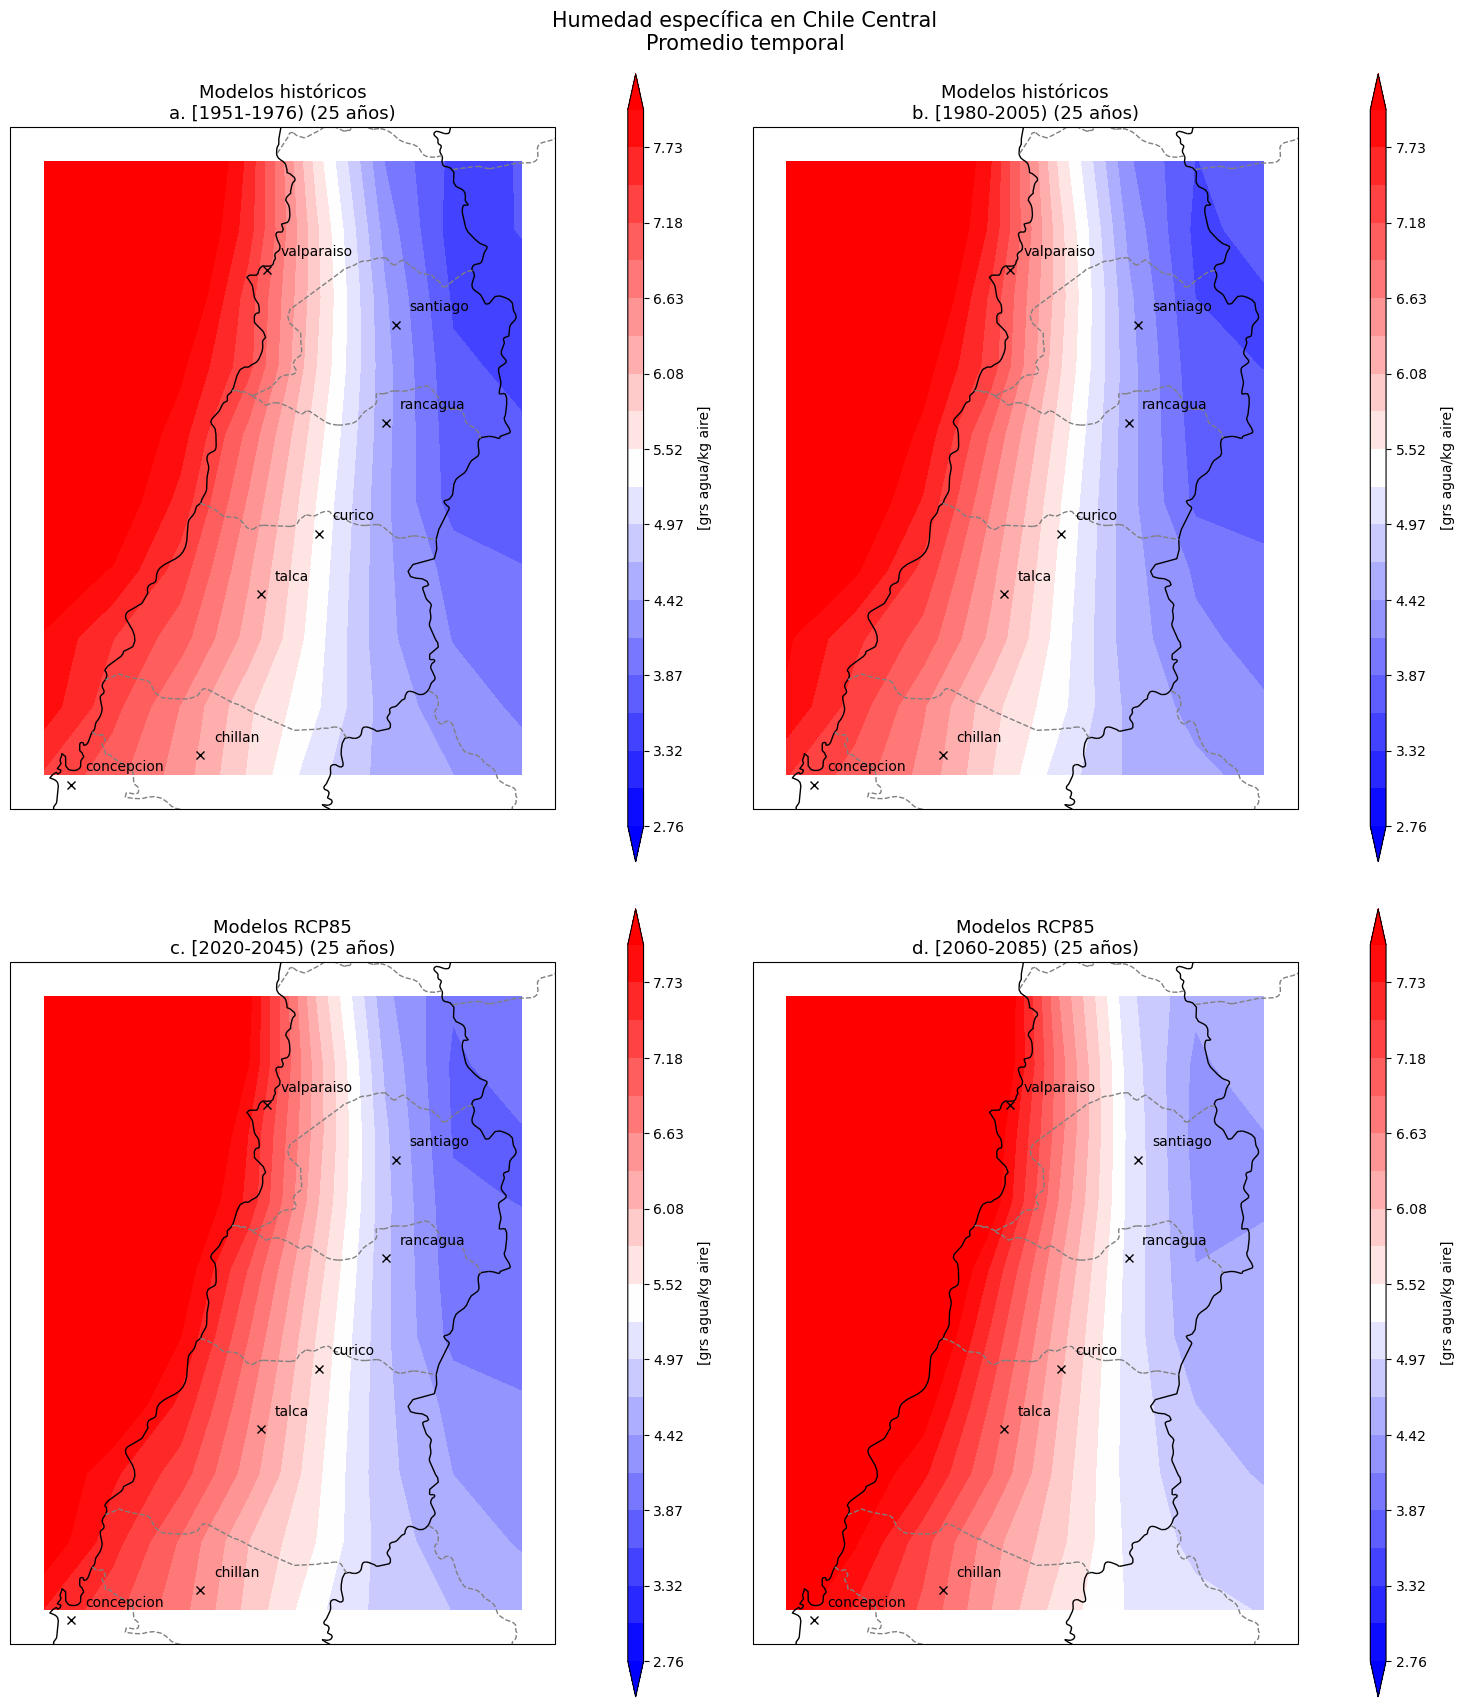

In [32]:
def kg2grams_formatter(x, pos):
    """
    Formatea un número en gramos.
    """
    return '{:.2f}'.format(x*1000)

# Graficamos los promedios temporales
map_mesh = np.meshgrid(lon_map, lat_map)
subplot_kw = {'projection': ccrs.PlateCarree()}
min_value_between_segments = min(huss_historical_data_total_segmentation_1['mean']['huss_temporal_mean'].min(), huss_historical_data_total_segmentation_2['mean']['huss_temporal_mean'].min(), huss_rcp85_data_total_segmentation_1['mean']['huss_temporal_mean'].min(), huss_rcp85_data_total_segmentation_2['mean']['huss_temporal_mean'].min())
max_value_between_segments = max(huss_historical_data_total_segmentation_1['mean']['huss_temporal_mean'].max(), huss_historical_data_total_segmentation_2['mean']['huss_temporal_mean'].max(), huss_rcp85_data_total_segmentation_1['mean']['huss_temporal_mean'].max(), huss_rcp85_data_total_segmentation_2['mean']['huss_temporal_mean'].max())
max_abs = max(abs(min_value_between_segments), abs(max_value_between_segments))
limit_value_multiplier = 0.8
contour_levels = np.linspace( min_value_between_segments * limit_value_multiplier, max_value_between_segments * limit_value_multiplier, 20)
# contour_levels = np.linspace( -max_abs * limit_value_multiplier, max_abs * limit_value_multiplier, 20)
contourf_kwargs = {'extend': 'both', 'transform': ccrs.PlateCarree(), 'cmap': 'bwr', 'levels': contour_levels}


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15, 18), subplot_kw=subplot_kw)
for i, ax in enumerate(axs.flatten()):
    if i == 0:
        data = huss_historical_data_total_segmentation_1['mean']['huss_temporal_mean']
        title = 'Modelos históricos\na. [1951-1976) (25 años)'
    elif i == 1:
        data = huss_historical_data_total_segmentation_2['mean']['huss_temporal_mean']
        title = 'Modelos históricos\nb. [1980-2005) (25 años)'
    elif i == 2:
        data = huss_rcp85_data_total_segmentation_1['mean']['huss_temporal_mean']
        title = 'Modelos RCP85\nc. [2020-2045) (25 años)'
    elif i == 3:
        data = huss_rcp85_data_total_segmentation_2['mean']['huss_temporal_mean']
        title = 'Modelos RCP85\nd. [2060-2085) (25 años)'

    
    # Graficamos los datos
    cf = ax.contourf(lon_map, lat_map, data, **contourf_kwargs)
    cbar = plt.colorbar(cf, ax=ax, orientation='vertical',
                        shrink=0.9, pad=0.1, aspect=50)
    # ax.gridlines(draw_labels=True, dms=True, x_inline=False,
    #              y_inline=False, crs=ccrs.PlateCarree(), zorder=1, alpha=0.5)

    ax.set_extent([chile_central_lon[0], chile_central_lon[1],
                   chile_central_lat[0], chile_central_lat[1]])
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), zorder=2)
    ax.add_feature(states_provinces, edgecolor='gray', zorder=2)
    ax.set_title(title, fontsize=13)
    cbar.ax.set_ylabel('[grs agua/kg aire]', fontsize=10, labelpad=10)
    cbar.ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(kg2grams_formatter))
    
    for city in cities.keys():
        ax.plot(cities[city][1], cities[city][0],
                transform=ccrs.PlateCarree(), marker='x', color='black')
        # text
        ax.text(cities[city][1] + 0.1, cities[city][0] +
                0.1, city, transform=ccrs.PlateCarree())
    fig.suptitle('Humedad específica en Chile Central\nPromedio temporal', fontsize=15, y=0.97)
fig.tight_layout()
plt.show()

In [43]:
# Creamos un diccionario para almacenar las diferencias de promedio temporal entre el primer segmento histórico y el segundo segmento RCP85 para cada modelo

huss_diff_s1historical_s2rcp85 = {}
for model in huss_historical_data_total_segmentation_1.keys():
    if model != 'mean':
        huss_diff_s1historical_s2rcp85[model] = {}
        # Calculamos las diferencias
        huss_diff_s1historical_s2rcp85[model]['abs_diff_temporal_mean'] = huss_rcp85_data_total_segmentation_2[model]['huss_temporal_mean'] - huss_historical_data_total_segmentation_1[model]['huss_temporal_mean']
        huss_diff_s1historical_s2rcp85[model]['abs_diff_spatial_mean'] = huss_rcp85_data_total_segmentation_2[model]['huss_spatial_mean'] - huss_historical_data_total_segmentation_1[model]['huss_spatial_mean']
        huss_diff_s1historical_s2rcp85[model]['percent_diff_temporal_mean'] = huss_diff_s1historical_s2rcp85[model]['abs_diff_temporal_mean'] / huss_historical_data_total_segmentation_1[model]['huss_temporal_mean'] * 100
        huss_diff_s1historical_s2rcp85[model]['percent_diff_spatial_mean'] = huss_diff_s1historical_s2rcp85[model]['abs_diff_spatial_mean'] / huss_historical_data_total_segmentation_1[model]['huss_spatial_mean'] * 100
        # Chequeamos el signo de la diferencia
        huss_diff_s1historical_s2rcp85[model]['sign_diff_temporal_mean'] = np.sign(huss_diff_s1historical_s2rcp85[model]['abs_diff_temporal_mean'])
        huss_diff_s1historical_s2rcp85[model]['sign_diff_spatial_mean'] = np.sign(huss_diff_s1historical_s2rcp85[model]['abs_diff_spatial_mean'])

In [58]:
# Calculamos la diferencia entre el primer segmento historico y ultimo segmento rcp85 de manera absoluta
diff_abs = huss_rcp85_data_total_segmentation_2['mean']['huss_temporal_mean'] - huss_historical_data_total_segmentation_1['mean']['huss_temporal_mean']

# Calculamos la diferencia entre el primer segmento historico y ultimo segmento rcp85 de manera porcentual
diff_percent = (huss_rcp85_data_total_segmentation_2['mean']['huss_temporal_mean'] - huss_historical_data_total_segmentation_1['mean']['huss_temporal_mean']) / huss_historical_data_total_segmentation_1['mean']['huss_temporal_mean'] * 100

# Comprobamos cuantos modelos tienen un signo de diferencia concordante con el cambio en el promedio
sign_diff_temporal_mean = np.sign(diff_abs)
count_matrix = np.zeros(sign_diff_temporal_mean.shape)
for model in huss_diff_s1historical_s2rcp85.keys():
    for j in range(len(sign_diff_temporal_mean)):
        for i in range(len(sign_diff_temporal_mean[0])):
            if sign_diff_temporal_mean[j][i] == huss_diff_s1historical_s2rcp85[model]['sign_diff_temporal_mean'][j][i]:
                count_matrix[j][i] += 1
significance_matrix = count_matrix / len(huss_diff_s1historical_s2rcp85.keys())


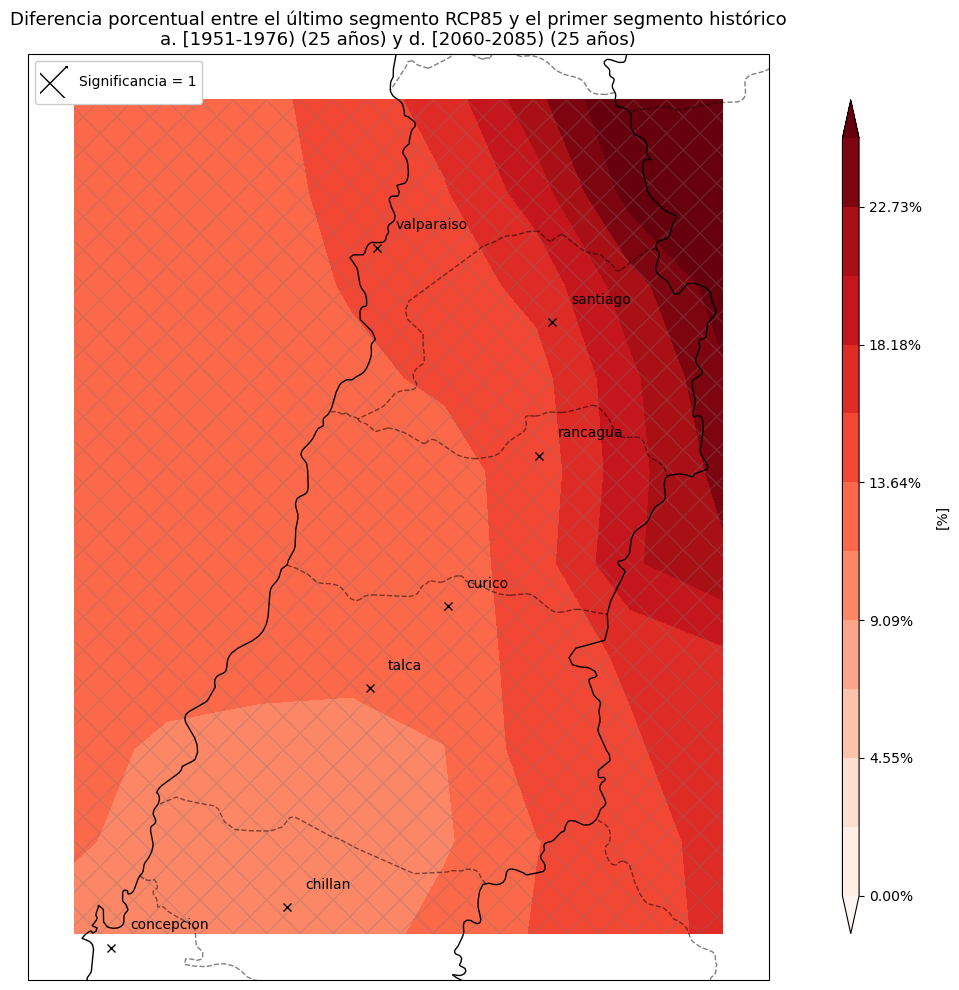

In [167]:
def percent_formatter(x, pos):
    """
    Formatea un número en porcentaje.
    """
    return '{:.2f}'.format(x) + '%'

# Graficamos la diferencia
map_mesh = np.meshgrid(lon_map, lat_map)
subplot_kw = {'projection': ccrs.PlateCarree()}
contour_levels = np.linspace(0, 25, 12)
contourf_kwargs = {'extend': 'both', 'transform': ccrs.PlateCarree(), 'cmap': 'Reds', 'levels': contour_levels}


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 10), subplot_kw=subplot_kw)
data = diff_percent
title = 'Diferencia porcentual entre el último segmento RCP85 y el primer segmento histórico\na. [1951-1976) (25 años) y d. [2060-2085) (25 años)'
# Graficamos los datos
cf = ax.contourf(lon_map, lat_map, data, **contourf_kwargs)
cbar = plt.colorbar(cf, ax=ax, orientation='vertical',
                    shrink=0.9, aspect=50)

ax.set_extent([chile_central_lon[0], chile_central_lon[1],
                chile_central_lat[0], chile_central_lat[1]])
ax.add_feature(cfeature.COASTLINE.with_scale('10m'))
ax.add_feature(cfeature.BORDERS.with_scale('10m'))
ax.add_feature(states_provinces, edgecolor=(0, 0, 0, 0.5))
ax.set_title(title, fontsize=13)
cbar.ax.set_ylabel('[%]', fontsize=10, labelpad=10)
cbar.ax.yaxis.set_major_formatter(
    mticker.FuncFormatter(percent_formatter))

for city in cities.keys():
    ax.plot(cities[city][1], cities[city][0],
            transform=ccrs.PlateCarree(), marker='x', color='black')
    # text
    ax.text(cities[city][1] + 0.1, cities[city][0] +
            0.1, city, transform=ccrs.PlateCarree())

cs = ax.contourf(lon_map, lat_map, significance_matrix>=1, levels=[0.5, 1.5], hatches='x', transform=ccrs.PlateCarree(), colors = 'none', extend='lower')

colors = [(0.490, 0.451, 0.451, 0.3)]
# For each level, we set the color of its hatch 
for i, collection in enumerate(cs.collections):
    collection.set_edgecolor(colors[i])
    collection.set_linewidth(0.)

# Leyenda de los hatches
artists, labels = cs.legend_elements()
legend1 = ax.legend(artists, ['Significancia = 1'], loc='upper left', fontsize=10, handleheight=3.2, framealpha=1)

# New bit here that handles changing the color of hatches
# Doing this also colors in the box around each level

fig.tight_layout()
plt.show()

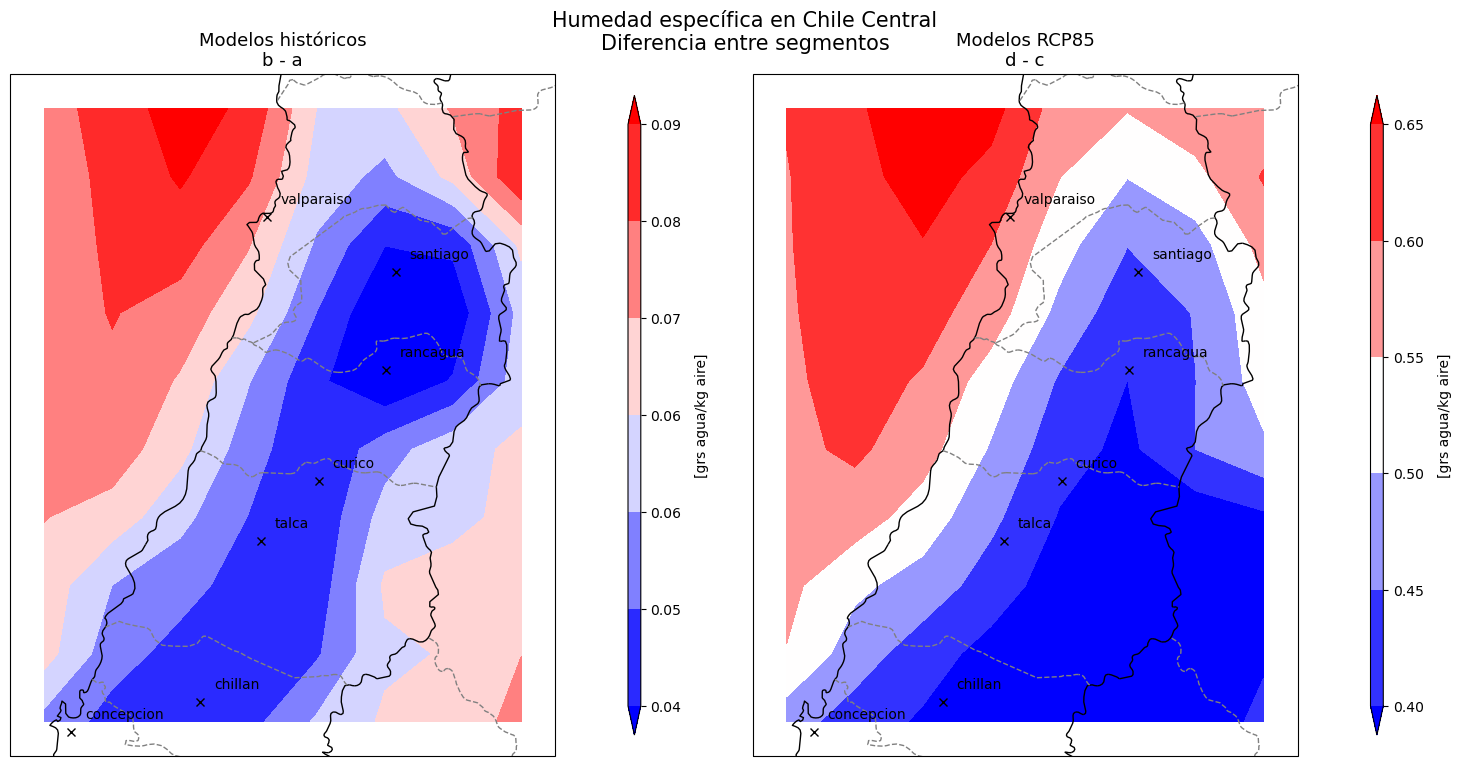

In [165]:
# Calculamos las diferencias entre segmentos de los promedios temporales
huss_historical_data_total_segmentation_1['mean']['huss_temporal_mean_diff'] = huss_historical_data_total_segmentation_2['mean']['huss_temporal_mean'] - huss_historical_data_total_segmentation_1['mean']['huss_temporal_mean']
huss_rcp85_data_total_segmentation_1['mean']['huss_temporal_mean_diff'] = huss_rcp85_data_total_segmentation_2['mean']['huss_temporal_mean'] - huss_rcp85_data_total_segmentation_1['mean']['huss_temporal_mean']

# Graficamos las diferencias entre segmentos de los promedios temporales
map_mesh = np.meshgrid(lon_map, lat_map)
subplot_kw = {'projection': ccrs.PlateCarree()}
min_value_between_segments = min(huss_historical_data_total_segmentation_1['mean']['huss_temporal_mean_diff'].min(), huss_rcp85_data_total_segmentation_1['mean']['huss_temporal_mean_diff'].min())
max_value_between_segments = max(huss_historical_data_total_segmentation_1['mean']['huss_temporal_mean_diff'].max(), huss_rcp85_data_total_segmentation_1['mean']['huss_temporal_mean_diff'].max())
max_abs = max(abs(min_value_between_segments), abs(max_value_between_segments))
limit_value_multiplier = 0.8
contour_levels = np.linspace( min_value_between_segments * limit_value_multiplier, max_value_between_segments * limit_value_multiplier, 20)
# contour_levels = np.linspace( -max_abs * limit_value_multiplier, max_abs * limit_value_multiplier, 20)
# contourf_kwargs = {'extend': 'both', 'transform': ccrs.PlateCarree(), 'cmap': 'bwr', 'levels': contour_levels}
contourf_kwargs = {'extend': 'both', 'transform': ccrs.PlateCarree(), 'cmap': 'bwr'}


fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8), subplot_kw=subplot_kw)
for i, ax in enumerate(axs.flatten()):
    if i == 0:
        data = huss_historical_data_total_segmentation_1['mean']['huss_temporal_mean_diff']
        title = 'Modelos históricos\nb - a'
    elif i == 1:
        data = huss_rcp85_data_total_segmentation_1['mean']['huss_temporal_mean_diff']
        title = 'Modelos RCP85\nd - c'

    
    # Graficamos los datos
    cf = ax.contourf(lon_map, lat_map, data, **contourf_kwargs)
    cbar = plt.colorbar(cf, ax=ax, orientation='vertical',
                        shrink=0.9, pad=0.1, aspect=50)
    # ax.gridlines(draw_labels=True, dms=True, x_inline=False,
    #              y_inline=False, crs=ccrs.PlateCarree(), zorder=1, alpha=0.5)

    ax.set_extent([chile_central_lon[0], chile_central_lon[1],
                   chile_central_lat[0], chile_central_lat[1]])
    ax.add_feature(cfeature.COASTLINE.with_scale('10m'), zorder=2)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), zorder=2)
    ax.add_feature(states_provinces, edgecolor='gray', zorder=2)
    ax.set_title(title, fontsize=13)
    cbar.ax.set_ylabel('[grs agua/kg aire]', fontsize=10, labelpad=10)
    cbar.ax.yaxis.set_major_formatter(
        mticker.FuncFormatter(kg2grams_formatter))
    
    for city in cities.keys():
        ax.plot(cities[city][1], cities[city][0],
                transform=ccrs.PlateCarree(), marker='x', color='black')
        # text
        ax.text(cities[city][1] + 0.1, cities[city][0] +
                0.1, city, transform=ccrs.PlateCarree())
    fig.suptitle('Humedad específica en Chile Central\nDiferencia entre segmentos', fontsize=15, y=0.97)
fig.tight_layout()
plt.show()